# Amazon users products network



In [ ]:
# Data loading
import json
import pickle

# Pre-processing
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm

# Ensure reproducibility
np.random.seed(904)

# Network
import networkx as nx
!pip install python-louvain
from community import community_louvain
!pip install powerlaw
import powerlaw

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
!pip install fa2_modified
from fa2_modified import ForceAtlas2
import matplotlib.patches as mpatches
from scipy.stats import linregress

# Text analysis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import math
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
import re
import regex
from collections import Counter

# Sentiment analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from matplotlib.lines import Line2D

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Pickle loading - write an updated version explaining how the pickles are made (which variables did we exclude from the original dataset)

From the old code that used the $\texttt{jsonl}$ files, we will be using the pickles we created with the reduced attributes and dataframe structure. So, upload $\texttt{reviews.pickle}$ and $\texttt{meta_df.pickle}$ files to colab and run the following code.

In [ ]:
# Load the review dataset
review_pkl = 'reviews.pickle'
with open(review_pkl, 'rb') as handle:
    review_df = pickle.load(handle)

In [ ]:
# Load the metadata dataset
meta_pkl = 'meta_df.pickle'
with open(meta_pkl, 'rb') as handle:
    meta_df = pickle.load(handle)

## Pre-processing

We start by looking at which variables the datasets contains

In [ ]:
review_df

rating                                               text  date  \
0           5.0              work great. use a new one every month  2018   
1           5.0                            Little on the thin side  2022   
2           5.0                   Quick delivery, fixed the issue!  2020   
3           5.0  I wasn't sure whether these were worth it or n...  2018   
4           5.0  Easy to install got the product expected to re...  2021   
...         ...                                                ...   ...   
2128600     5.0                                       As described  2021   
2128601     3.0  I have tried multiple times with different reu...  2021   
2128602     5.0  Exact fit for Sears Kenmore model 36275585891....  2020   
2128603     5.0  Love this!! It doesn’t keep the ice cold but t...  2020   
2128604     1.0  Did not work. Not the same model as the OEM we...  2016   

                              user_id parent_asin  
0        AGKHLEW2SOWHNMFQIJGBECAF7INQ  B01N0TQ0OH  
1        AHWWLSPCJMALVHDDVSUGICL6RUCA  B07DD37QPZ  
2        AHZIJGKEWRTAEOZ673G5B3SNXEGQ  B082W3Z9YK  
3        AFGUPTDFAWOHHL4LZDV27ERDNOYQ  B078W2BJY8  
4        AELFJFAXQERUSMTXJQ6SYFFRDWMA  B08C9LPCQV  
...                               ...         ...  
2128600  AG6IN4MOTWF3743PKIPHYA2S7GXA  B097948QRP  
2128601  AHVKX5FONDMQVOA7XLMPAH6EGZ2Q  B0C6XG2JSG  
2128602  AEYETSNK5VL6ZSLN32EE6VCOAYFA  B07QKBMPG2  
2128603  AHIJLNIXWVFQFWJV3OGGQOHONGMQ  B07H7SGQ52  
2128604  AGIOA4MS625NBQAUNM4PMJJX3Q7Q  B0C5BHXVH1  

[2128605 rows x 5 columns]

In [ ]:
meta_df

title parent_asin  \
0      ROVSUN Ice Maker Machine Countertop, Make 44lb...  B08Z743RRD   
1      HANSGO Egg Holder for Refrigerator, Deviled Eg...  B097BQDGHJ   
2      Clothes Dryer Drum Slide, General Electric, Ho...  B00IN9AGAE   
3      154567702 Dishwasher Lower Wash Arm Assembly f...  B0C7K98JZS   
4                            Whirlpool W10918546 Igniter  B07QZHQTVJ   
...                                                  ...         ...   
94322                                          AMI PARTS  B07S5YQH3N   
94323  WP10442411 Refrigerator Defrost Thermostat Rep...  B082TY87VG   
94324    3957749 DRYER KNOB WHIRLPOOL ROPER USED PART fc  B001EY0RIQ   
94325  5 Dryer Timer Knob Replacement for Frigidaire ...  B07JZFJYPK   
94326  Edgewater Parts AP2039084-4 Rack Rollers Compa...  B01GGKIPE0   

                  main_category               store  num_ratings  avg_rating  \
0       Industrial & Scientific              ROVSUN           61         3.7   
1      Tools & Home Improvement              HANSGO           75         4.2   
2      Tools & Home Improvement                  GE           18         3.5   
3      Tools & Home Improvement             folosem           26         4.5   
4      Tools & Home Improvement           Whirlpool           12         3.8   
...                         ...                 ...          ...         ...   
94322  Tools & Home Improvement           AMI PARTS           22         4.1   
94323  Tools & Home Improvement  UpStart Components            2         5.0   
94324  Tools & Home Improvement           Whirlpool            1         5.0   
94325  Tools & Home Improvement  UpStart Components            1         5.0   
94326  Tools & Home Improvement     Edgewater Parts            2         5.0   

                                           category_list  
0      [Appliances, Refrigerators, Freezers & Ice Mak...  
1      [Appliances, Parts & Accessories, Refrigerator...  
2                      [Appliances, Parts & Accessories]  
3      [Appliances, Parts & Accessories, Dryer Parts ...  
4                      [Appliances, Parts & Accessories]  
...                                                  ...  
94322  [Appliances, Parts & Accessories, Dryer Parts ...  
94323                  [Appliances, Parts & Accessories]  
94324                  [Appliances, Parts & Accessories]  
94325  [Appliances, Parts & Accessories, Dryer Parts ...  
94326                  [Appliances, Parts & Accessories]  

[94327 rows x 7 columns]

### Since the datasets are relatively large, it would be advantageous to reduce their size. Given that the dataset extends back to a period before online shopping was popular, the number of reviews per year is analyzed to identify the most relevant years.

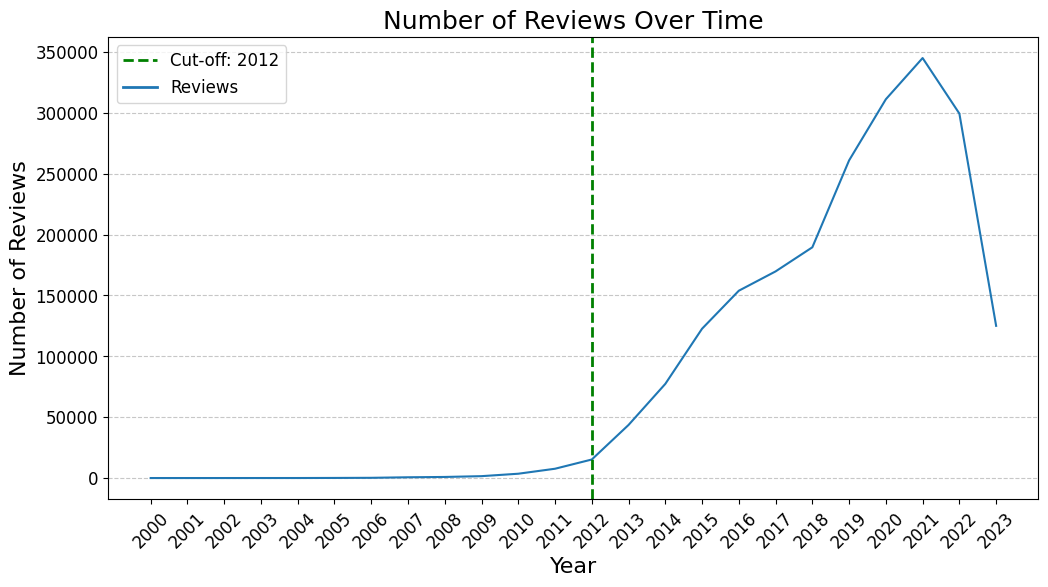

In [ ]:
# Extracting only the year for simplicity
review_df['date'] = review_df['date'].dt.year
# Plot trend of reviews over time
review_df.groupby('date').size().plot(kind = 'line', figsize = (12, 6))
# Cut-off
plt.axvline(2012, color="green", linestyle='--', linewidth=2)
# Add title and labels
plt.title('Number of Reviews Over Time', fontsize = 18)
plt.xlabel('Year', fontsize = 16)
plt.xticks(ticks = np.arange(review_df['date'].min(), review_df['date'].max() + 1), rotation = 45)
plt.ylabel('Number of Reviews', fontsize = 16)
plt.tick_params(axis = 'both', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha = 0.7)
# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='green', linestyle='--', linewidth=2, label=f'Cut-off: 2012'),
    Line2D([0], [0], linestyle='-', linewidth=2, label=f'Reviews')
]

# Add custom legend to the plot
plt.legend(handles=legend_elements, loc="upper left", fontsize = 12)
# save as svg
plt.savefig('review_trends.svg', format='svg')
plt.show()

We identify possible values for the main category of the products, which in this case corresponds to the product's domain.





As there is a noticeable increase in reviews between 2012 and 2013, we will restrict the dataset to include data from 2012 to 2023.

In [ ]:
# Get products per user before cut-off
per_user_origiginal = review_df.groupby('user_id')['parent_asin'].apply(list)
print(f"Total number of users in the data before pre-processing is: {len(per_user_origiginal)}")

# Number of reviews before cut-off
print(f"Total number of reviews in the data before pre-processing is: {len(review_df)}")

# Number of products before cut-off
number_of_products_original = len(set(review_df['parent_asin']))
print(f"Total number of products in the data before pre-processing is: {number_of_products_original}\n")

Total number of users in the data before pre-processing is: 1755732
Total number of reviews in the data before pre-processing is: 2128605
Total number of products in the data before pre-processing is: 94319



In [ ]:
# Discard rows with dates before 2012
review_df = review_df[review_df['date'] >= 2012]

# Get products per user after cut-off
per_user_cutoff = review_df.groupby('user_id')['parent_asin'].apply(list)
print(f"Total number of users in the data after cut-off is: {len(per_user_cutoff)}")

# Number of reviews after cut-off
print(f"Total number of reviews in the data after cut-off is: {len(review_df)}")

# Number of products after cut-off
number_of_products_cutoff = len(set(review_df['parent_asin']))
print(f"Total number of products in the data after cut-off is: {number_of_products_cutoff}")

Total number of users in the data after cut-off is: 1744482
Total number of reviews in the data after cut-off is: 2114101
Total number of products in the data after cut-off is: 93630


#### Among the product domains it turns out that some products do not belong to any of main_category and therefore we discard them in both the metadata and the reviews.




In [ ]:
# Remove products with no main category
meta_df = meta_df.dropna(subset=['main_category']).reset_index(drop=True)
# Discard rows with these 'parent_asin' values in the review data
review_df = review_df[review_df['parent_asin'].isin(meta_df['parent_asin'])]

# Get products per user after discarding products without main category
per_user_main_category = review_df.groupby('user_id')['parent_asin'].apply(list)
print(f"Total number of users in the data after discarding products without main category is: {len(per_user_main_category)}")

# Number of reviews after discarding products without main category
print(f"Total number of reviews in the data after discarding products without main category is: {len(review_df)}")

# Number of products after discarding products without main category
number_of_products_main_category  = len(set(review_df['parent_asin']))
print(f"Total number of products in the data after discarding products without main category is: {number_of_products_main_category}")

Total number of users in the data after discarding products without main category is: 1723923
Total number of reviews in the data after discarding products without main category is: 2085948
Total number of products in the data after discarding products without main category is: 89050


In [ ]:
# Display the total number of main categories
print(f"The total number of distinct main categories is: {len(set(meta_df['main_category'].values))} \n")

# Get unique main category
possible_main_categories = set(meta_df['main_category'])

# Display subcategories
print('The main categories are:')
print('-' * 61)

# Define the width for each column and number of columns
column_width = 30
columns = 2

# Convert the set to a sorted list for consistent display
maincategory_list = sorted(list(possible_main_categories))

# Iterate over subcategories and format into columns
for i in range(0, len(maincategory_list), columns):
    row = maincategory_list[i:i + columns]
    print(' | '.join(maincategory.ljust(column_width) for maincategory in row))

The total number of distinct main categories is: 30 

The main categories are:
-------------------------------------------------------------
AMAZON FASHION                 | All Beauty                    
All Electronics                | Amazon Home                   
Appliances                     | Arts, Crafts & Sewing         
Automotive                     | Baby                          
Books                          | Camera & Photo                
Car Electronics                | Cell Phones & Accessories     
Computers                      | Digital Music                 
GPS & Navigation               | Grocery                       
Health & Personal Care         | Home Audio & Theater          
Industrial & Scientific        | Movies & TV                   
Musical Instruments            | Office Products               
Pet Supplies                   | Portable Audio & Accessories  
Premium Beauty                 | Software                      
Sports & Outdoors          

#### When examining the $\texttt{category_list}$, products with empty lists are discarded in both the meta data and the reviews.

In [ ]:
# Find rows where 'category_list' is empty
empty_category = meta_df[meta_df['category_list'].apply(lambda x: len(x) == 0 if isinstance(x, list) else False)]

# Extract the 'parent_asin' values from these rows
empty_category_parent_asin = empty_category['parent_asin'].tolist()

# Discard rows with these 'parent_asin' values in the metadata
meta_df = meta_df[~meta_df['parent_asin'].isin(empty_category_parent_asin)].reset_index(drop=True)

In [ ]:
# Discard rows with these 'parent_asin' values in the review data
review_df = review_df[~review_df['parent_asin'].isin(empty_category_parent_asin)].reset_index(drop=True)

# Get products per user after discarding products without sub category
per_user_sub_category = review_df.groupby('user_id')['parent_asin'].apply(list)
print(f"Total number of users in the data after discarding products without sub category is: {len(per_user_sub_category)}")

# Number of reviews after discarding products without sub category
print(f"Total number of reviews in the data after discarding products without sub category is: {len(review_df)}")

# Number of products after discarding products without sub category
number_of_products_sub_category  = len(set(review_df['parent_asin']))
print(f"Total number of products in the data after discarding products without sub category is: {number_of_products_sub_category}")

Total number of users in the data after discarding products without sub category is: 1703379
Total number of reviews in the data after discarding products without sub category is: 2058398
Total number of products in the data after discarding products without sub category is: 85778


#### Define the $\texttt{subCategory}$ that the products belongs to as the last category in their $\texttt{category_list}$




In [ ]:
# Create the 'subCategory' column based on the last item of 'category_list'
meta_df['subCategory'] = meta_df['category_list'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else None)

# Get unique subcategories
possible_subcategories = set(meta_df['subCategory'])

# Display the total number of subcategories
print(f"The total number of distinct subcategories is: {len(possible_subcategories)} \n")

# Display subcategories
print('The subcategories are:')
print('-' * 122)

# Define the width for each column and number of columns
column_width = 40
columns = 3

# Convert the set to a sorted list for consistent display
subcategory_list = sorted(list(possible_subcategories))

# Iterate over subcategories and format into columns
for i in range(0, len(subcategory_list), columns):
    row = subcategory_list[i:i + columns]
    print(' | '.join(subcategory.ljust(column_width) for subcategory in row))

The total number of distinct subcategories is: 92 

The subcategories are:
--------------------------------------------------------------------------------------------------------------------------
Absorption Sleeves                       | Accessories                              | Air Conditioner Parts & Accessories     
Air Filters                              | All-in-One Combination Washers & Dryers  | Bag Sealers                             
Baskets                                  | Beverage Refrigerator Replacement Parts  | Beverage Refrigerators                  
Bins                                     | Blowers                                  | Built-In Dishwashers                    
Burner Rings                             | Burners                                  | Chemicals                               
Chest Freezers                           | Combination Microwave & Wall Ovens       | Cooktop Parts & Accessories             
Cooktops                                

#### Then we are going to examine how many stores the dataset contains and if a product is not associated with a store, the store will be considered as "UNSPECIFIED STORE". Moreover, since some of the same stores are notated with different combinations of upper- and lowercase letters, all letters are converted to uppercase.

In [ ]:
# Verify that all strings in the 'store' column are converted to uppercase
# Convert all strings in the 'store' column to uppercase
possible_stores = set(meta_df['store'].str.upper())

# Regular expression to match uppercase letters (including accented and special characters), numbers, and special characters
pattern = r'^[\p{Lu}\d\W_]+$'

# Find stores that do not match the pattern
invalid_stores = [store for store in possible_stores if isinstance(store, str) and not regex.match(pattern, store)]

# Display the invalid stores
if invalid_stores:
    print("The names of all of the stores are in uppercase, except the following store:")
    print(76*'-')
    print("\n".join(invalid_stores))
else:
    print("All stores conform to the rule.")

The names of all of the stores are in uppercase, except the following store:
----------------------------------------------------------------------------
通用
カリタ(KALITA)
无牌
ZERO JAPAN(ゼロジャパン)
无


In [ ]:
# Count the number of different stores
print(f"The number of different stores which sold appliance products in Amazon is: {len(possible_stores)}")

# Fill missing values in the 'store' column with 'UNSPECIFIED STORE'
meta_df['store'] = meta_df['store'].fillna('UNSPECIFIED STORE')

# Display the number of 'UNSPECIFIED STORE'
unspecified_stores = meta_df['store'].value_counts().get('UNSPECIFIED STORE', 0)
print(f"The number of unspecified stores is: {unspecified_stores}")

The number of different stores which sold appliance products in Amazon is: 11685
The number of unspecified stores is: 607


However, these letters may not be in uppercase although it seems like it when looking at "ZERO JAPAN" and "KALITA" being a part of 2 out of 5 store names.

#### Check if there are duplicated rows in the dataset containing the reviews. In other words, check if a user reviews the same product more than once at the same time.

In [ ]:
# Find duplicated rows
duplicates = review_df[review_df.duplicated(subset=['user_id', 'date', 'parent_asin'])]

# Display the number of duplicated rows
print(f"Number of duplicated rows: {len(duplicates)}")

Number of duplicated rows: 22597


Discard the duplicated rows from the review dataset

In [ ]:
# Drop the duplicated rows
df_no_duplicates = review_df.drop_duplicates(subset=['user_id','date','parent_asin']).reset_index(drop=True)

# Check if the number of duplicated rows are dropped
print(f"Difference in number of rows in original review data and the data where the duplicates are removed: {len(review_df) - len(df_no_duplicates)}")

Difference in number of rows in original review data and the data where the duplicates are removed: 22597


It is confirmed above that the number of discarded rows is the same as the number of duplicated rows.


For convenience is the $\texttt{df_no_duplicates}$ dataframe renamed back to $\texttt{review_df}$

In [ ]:
# Renamed the updated dataframe
review_df = df_no_duplicates

In [ ]:
# Get products per user after duplicate reviews
per_user_no_duplicates = review_df.groupby('user_id')['parent_asin'].apply(list)
print(f"Total number of users in the data after discarding duplicate reviews is: {len(per_user_no_duplicates)}")

# Number of reviews after duplicate reviews
print(f"Total number of reviews in the data after discarding duplicate reviews is: {len(review_df)}")

# Number of products after duplicate reviews
number_of_products_no_duplicates  = len(set(review_df['parent_asin']))
print(f"Total number of products in the data after duplicate reviews is: {number_of_products_no_duplicates}")

Total number of users in the data after discarding duplicate reviews is: 1703379
Total number of reviews in the data after discarding duplicate reviews is: 2035801
Total number of products in the data after duplicate reviews is: 85778


#### The distribution of number of reviews per user

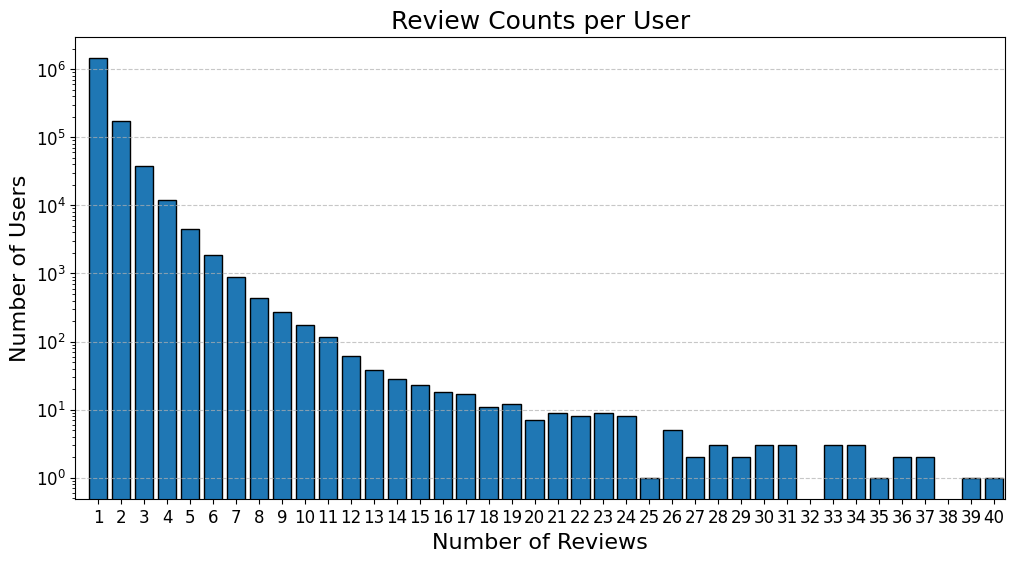

In [ ]:
# Filter users with at least two reviews
user_review_counts = review_df['user_id'].value_counts()
users_with_multiple_reviews = user_review_counts[user_review_counts >= 1]

# Define bins for histogram
bins = np.arange(users_with_multiple_reviews.min(), users_with_multiple_reviews.max() + 2) - 0.5
counts, edges = np.histogram(users_with_multiple_reviews, bins=bins)

# Calculate the midpoints of the bins
midpoints = edges[:-1] + 0.5

# Plot the histogram
plt.figure(figsize = (12, 6))
plt.bar(midpoints, counts, width = 0.8, edgecolor = 'black')
plt.title('Review Counts per User', fontsize = 18)
plt.xlabel('Number of Reviews', fontsize = 16)
plt.ylabel('Number of Users', fontsize = 16)
# log scale
plt.yscale('log')
plt.xticks(ticks = np.arange(users_with_multiple_reviews.min(), users_with_multiple_reviews.max() + 1))
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.xlim(0, 40.5)
plt.tick_params(axis = 'both', labelsize = 12)
plt.savefig('review_counts_per_user.svg', format = 'svg')
plt.show()

In [ ]:
max_reviews = users_with_multiple_reviews.max()
print(f"The maximum number of reviews by a single user is: {max_reviews}")

The maximum number of reviews by a single user is: 108


In order to get a better visualization of the number of reviews, we have chosen to limit the $x$-axis to 40, as not many users have written more than 40 reviews. However, the user with the highest number of reviews has written 108.

#### As we are interested in investigating the co-purchases of Amazon products, we discard users and their review if they have only purchased 1 product

In [ ]:
# Get products per user
per_user = review_df.groupby('user_id')['parent_asin'].apply(list)

# Filter users with more than one unique 'parent_asin'
per_user_clean = per_user[per_user.apply(len) > 1]

# Remove reviews from users that are not in the per_user_clean
review_df = review_df[review_df['user_id'].isin(per_user_clean.index)]

In [ ]:
# Number of users when only including users with more than one review
print(f"Total number of users in the data with more than one review: {len(per_user_clean)}")

# Number of reviews when only including users with more than one review
print(f"Total number of reviews in the data after the constrain: {len(review_df)}")

# Number of products when only including users with more than one review
number_of_products_review_contrain  = len(set(review_df['parent_asin']))
print(f"Total number of products in the data after the constrain: {number_of_products_review_contrain}")

Total number of users in the data with more than one review: 233268
Total number of reviews in the data after the constrain: 565690
Total number of products in the data after the constrain: 55747


#### Do we still have the same number of main categories, sub categories and stores after preprocessing?

In [ ]:
# Iterate over each list in per_user_clean and extracts all parent_asin values
# into a single flat list to create a unique set
products_from_per_user_clean = set([asin for sublist in per_user_clean for asin in sublist])

# Remove rows in meta_df where parent_asin is in the flattened set
meta_df_after_preprocessing = meta_df[~meta_df['parent_asin'].isin(products_from_per_user_clean)].reset_index(drop=True)

# Display the total number of main categories
print(f"The total number of distinct main categories after preprocessing is: {len(set(meta_df_after_preprocessing['main_category'].values))} \n")

# Get unique main category
main_categories_after_preprocessing = set(meta_df_after_preprocessing['main_category'])

# Display subcategories
print('The main categories are:')
print('-' * 61)

# Define the width for each column and number of columns
column_width = 30
columns = 2

# Convert the set to a sorted list for consistent display
maincategory_list_after_preprocessing = sorted(list(main_categories_after_preprocessing))

# Iterate over subcategories and format into columns
for i in range(0, len(maincategory_list_after_preprocessing), columns):
    row = maincategory_list_after_preprocessing[i:i + columns]
    print(' | '.join(maincategory.ljust(column_width) for maincategory in row))

The total number of distinct main categories after preprocessing is: 27 

The main categories are:
-------------------------------------------------------------
AMAZON FASHION                 | All Beauty                    
All Electronics                | Amazon Home                   
Appliances                     | Arts, Crafts & Sewing         
Automotive                     | Baby                          
Books                          | Camera & Photo                
Car Electronics                | Cell Phones & Accessories     
Computers                      | Digital Music                 
Grocery                        | Health & Personal Care        
Home Audio & Theater           | Industrial & Scientific       
Movies & TV                    | Musical Instruments           
Office Products                | Pet Supplies                  
Portable Audio & Accessories   | Premium Beauty                
Sports & Outdoors              | Tools & Home Improvement      
Toys & 

In [ ]:
# Get unique subcategories
subcategories_after_preprocessing = set(meta_df_after_preprocessing['subCategory'])

# Display the total number of subcategories
print(f"The total number of distinct subcategories is: {len(subcategories_after_preprocessing)} \n")

# Display subcategories
print('The subcategories are:')
print('-' * 122)

# Define the width for each column and number of columns
column_width = 40
columns = 3

# Convert the set to a sorted list for consistent display
subcategory_list_after_preprocessing = sorted(list(subcategories_after_preprocessing))

# Iterate over subcategories and format into columns
for i in range(0, len(subcategory_list_after_preprocessing), columns):
    row = subcategory_list_after_preprocessing[i:i + columns]
    print(' | '.join(subcategory.ljust(column_width) for subcategory in row))

The total number of distinct subcategories is: 86 

The subcategories are:
--------------------------------------------------------------------------------------------------------------------------
Absorption Sleeves                       | Accessories                              | Air Conditioner Parts & Accessories     
All-in-One Combination Washers & Dryers  | Bag Sealers                              | Baskets                                 
Beverage Refrigerator Replacement Parts  | Beverage Refrigerators                   | Bins                                    
Blowers                                  | Built-In Dishwashers                     | Burner Rings                            
Burners                                  | Chemicals                                | Chest Freezers                          
Combination Microwave & Wall Ovens       | Cooktop Parts & Accessories              | Cooktops                                
Countertop Dishwashers                  

In [ ]:
# Get unique store
stores_after_preprocessing = set(meta_df_after_preprocessing['store'])

# Count the number of different stores
print(f"The number of different stores which sold appliance products in Amazon is: {len(stores_after_preprocessing)}")

# Display the number of 'UNSPECIFIED STORE'
unspecified_stores_after_preprocessing = meta_df_after_preprocessing['store'].value_counts().get('UNSPECIFIED STORE', 0)
print(f"The number of unspecified stores is: {unspecified_stores_after_preprocessing}")

The number of different stores which sold appliance products in Amazon is: 6488
The number of unspecified stores is: 301


## Create the graph which is weighted with respect to the co-purchases

In [ ]:
# Initialize set to store products across users
pr = set()
# Iterate over each user that has more than one review
for prod_list in per_user_clean:
  # Add products to set (automatically ensures no duplicates)
  pr.update(prod_list)

# Initialize graph
G = nx.Graph()
# Use the products to create nodes
G.add_nodes_from(pr)

# iterate over products each user bought
for prods in tqdm(per_user_clean):
    # for each pair of products the user bought
    for i, prod in enumerate(prods):
        for j, other_prod in enumerate(prods):
            # if products are different
            if i<j:
                # if the edge already exists
                if G.has_edge(prod, other_prod):
                    # increment the weight
                    G[prod][other_prod]['weight'] += 1
                else:
                    # add the edge with weight 1
                    G.add_edge(prod, other_prod, weight = 1)

100%|██████████| 233268/233268 [00:02<00:00, 96777.19it/s]


In [ ]:
print('Number of nodes in the graph:', G.number_of_nodes())
print('Number of edges in the graph:', G.number_of_edges())

Number of nodes in the graph: 55747
Number of edges in the graph: 476659


## Network analysis

In [ ]:
# Calculate the average degree
avg_degree = 2*G.number_of_edges() / G.number_of_nodes()
print(f"Average degree of the graph: {avg_degree:.3f}")

Average degree of the graph: 17.101


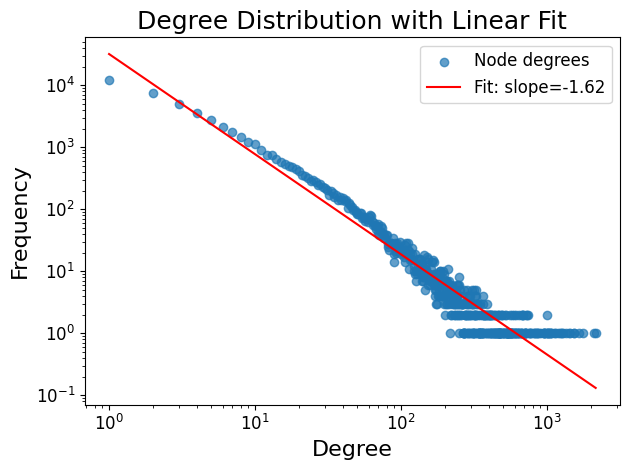

In [ ]:
# Extract the largest connected component
G_largest_cc = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# Compute the degree of nodes
degrees = [val for (node, val) in G_largest_cc.degree()]

# Compute the frequency of each degree
unique_degrees = range(1, max(degrees) + 1)
freqs = [degrees.count(x) for x in unique_degrees]

# Convert data to log scale
log_degrees = np.log10([d for d, f in zip(unique_degrees, freqs) if f > 0])
log_freqs = np.log10([f for f in freqs if f > 0])

# Perform linear regression on the log-log data
slope, intercept, r_value, p_value, std_err = linregress(log_degrees, log_freqs)

# Plot the degree distribution
plt.scatter(unique_degrees, freqs, label='Node degrees', alpha = 0.7)
plt.plot(
    unique_degrees,
    10 ** (slope * np.log10(unique_degrees) + intercept),
    label=f'Fit: slope={slope:.2f}',
    color='red'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Degree Distribution with Linear Fit', fontsize = 18)
plt.tick_params(axis = 'both', labelsize = 12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig('degree_distribution_with_fit.svg', format='svg')
plt.show()

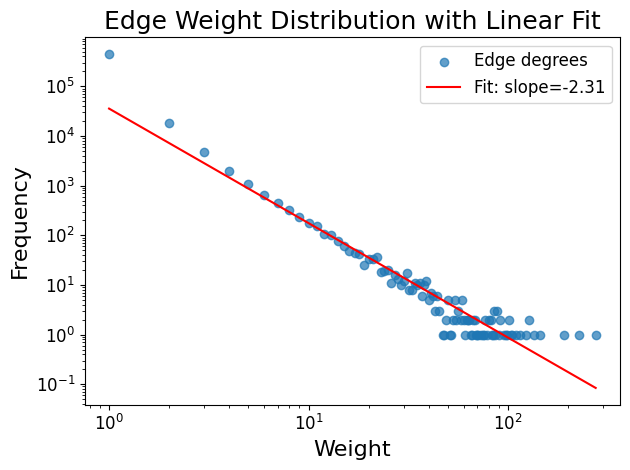

In [ ]:
# Extract edge weights from the largest connected component
weights = [G_largest_cc[u][v]['weight'] for u, v in G_largest_cc.edges()]

# Compute frequency of each edge weight
unique_weights = range(1, max(weights) + 1)
freqs = [weights.count(x) for x in unique_weights]

# Convert data to log scale (only for non-zero frequencies to avoid log(0))
log_weights = np.log10([w for w, f in zip(unique_weights, freqs) if f > 0])
log_freqs = np.log10([f for f in freqs if f > 0])

# Perform linear regression on the log-log data
slope, intercept, r_value, p_value, std_err = linregress(log_weights, log_freqs)

# Plot the edge weight distribution
plt.scatter(unique_weights, freqs, label = 'Edge degrees', alpha = 0.7)
plt.plot(
    unique_weights,
    10 ** (slope * np.log10(unique_weights) + intercept),
    label = f'Fit: slope={slope:.2f}',
    color = 'red'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Weight', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Edge Weight Distribution with Linear Fit', fontsize = 18)
plt.tick_params(axis = 'both', labelsize = 12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig('edge_weight_distribution_with_fit.svg', format='svg')
plt.show()

In [ ]:
# Compute power-law
fit = powerlaw.Fit(degrees, discrete=True)
print(48*'-')

# Find the power-law exponent (alpha)
# It describes the slope of the degree distribution on a log-log scale
print(f"The power-law exponent (alpha): {fit.power_law.alpha:.3f} \n")
# Find minimum degree where data starts to follow the power-law behavior
print(f"Minimum degree for power-law behavior: {fit.power_law.xmin:.0f}")

Calculating best minimal value for power law fit
------------------------------------------------
The power-law exponent (alpha): 2.766 

Minimum degree for power-law behavior: 150


When $\alpha$ is between 2 and 3, the graph often shows properties of a scale-free network.

In [ ]:
# Nodes in largest connected component
print(f"The number of nodes in the largest connected component is {G_largest_cc.number_of_nodes()}")

# Number of per_user_clean who reviewed the nodes in largest cc
# Initiate counter
count_us = 0
# Iterate over users in per_user_clean
for user in per_user_clean:
  # Iterate over products reviewed by current user
  for prod in user:
    # Check if proct is in LCC
    if prod in G_largest_cc.nodes():
      # If so, update counter
      count_us += 1
      # Stop checking the current user
      break
print(f"The number of users in the largest connected component is {count_us}")

# Calculate number of reviews (sum) represented in the GCC
# where the edge weights represent the number of reviews between two nodes
# u = nodes
# v = edge
# w = weight
# The list extracts (w) for all edges in the graph
largest_cc_reviews = sum([w for u,v,w in G_largest_cc.edges(data='weight')])
print(f"The number of reviews in the largest connected component is {largest_cc_reviews}")

The number of nodes in the largest connected component is 54350
The number of users in the largest connected component is 232572
The number of reviews in the largest connected component is 550416


#### Analyzing components

In [ ]:
# Creat a list containing list the connected components in the graph
ccs = list(nx.connected_components(G))

# Summary of nodes in the components
print("Amount of components in the network: ", len(ccs))
print(f"Amount of nodes in Gigant Connected Component: {G_largest_cc.number_of_nodes()} \n")

print("Max amount on nodes in component (not gcc): ", max([len(c) for c in ccs if len(c) < G_largest_cc.number_of_nodes()]))
print(f"Amount of nodes in the smallest component: {min([len(c) for c in ccs])}")
print("Amount on nodes not in gcc: ", G.number_of_nodes() - G_largest_cc.number_of_nodes())

Amount of components in the network:  674
Amount of nodes in Gigant Connected Component: 54350 

Max amount on nodes in component (not gcc):  4
Amount of nodes in the smallest component: 2
Amount on nodes not in gcc:  1397


#### Highest degree node

In [ ]:
# Initialize variables to track the node with the highest degree and its degree
max_degree = 0
max_node = None

# Iterate over all nodes in the largest connected component
for node in G_largest_cc.nodes():
    # Get the degree of the current node
    degree = G_largest_cc.degree(node)

    # Update the maximum degree and the corresponding node if a higher degree is found
    if degree > max_degree:
        max_degree = degree
        max_node = node

# Print the node with the highest degree and its degree
print(f"The node with the highest degree is {max_node} with a degree of {max_degree}")

The node with the highest degree is B07RNJY499 with a degree of 2154


In [ ]:
# Show the node in the meta data
meta_df[meta_df['parent_asin'] == max_node]

title parent_asin  \
25558  iPartPlusMore Reusable Coffee Filters Compatib...  B07RNJY499   

      main_category           store  num_ratings  avg_rating  \
25558   Amazon Home  iPartsPlusMore        41845         4.4   

                                           category_list       subCategory  
25558  [Small Appliance Parts & Accessories, Coffee &...  Reusable Filters

#### The most central node

In [ ]:
# Degree centrality
degree_centrality = nx.degree_centrality(G_largest_cc)

# Most central node
max_degree_centrality = max(degree_centrality, key = degree_centrality.get)

print(f"The node with the highest degree centrality is {max_degree_centrality} with a degree centrality of {degree_centrality[max_degree_centrality]:.3f}")

The node with the highest degree centrality is B07RNJY499 with a degree centrality of 0.040


In [ ]:
# Show the node in the meta data
meta_df[meta_df['parent_asin'] == max_degree_centrality]

title parent_asin  \
25558  iPartPlusMore Reusable Coffee Filters Compatib...  B07RNJY499   

      main_category           store  num_ratings  avg_rating  \
25558   Amazon Home  iPartsPlusMore        41845         4.4   

                                           category_list       subCategory  
25558  [Small Appliance Parts & Accessories, Coffee &...  Reusable Filters

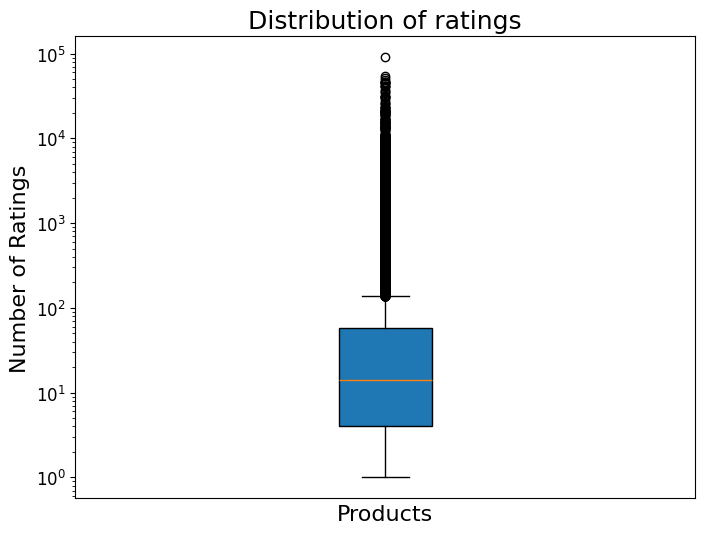

In [ ]:
# Plot distribution of num_ratings in boxplot
ratings = meta_df['num_ratings']

# Plot the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(ratings, vert=True, patch_artist=True)
# Apply logarithmic scale to the y-axis for easier interpretation
plt.yscale('log')
plt.title('Distribution of ratings', fontsize = 18)
plt.ylabel('Number of Ratings', fontsize = 16)
plt.xlabel('Products', fontsize = 16)
plt.tick_params(axis = 'y', labelsize = 12)
# Remove x-ticks
plt.xticks([])
plt.savefig('num_ratings_boxplot.svg', format = 'svg')
plt.show()

In [ ]:
# The count of products with more reviews than the most central product
print("Amount of products with more reviews than the most central product: ", len(ratings[ratings > 41845]))
# The count of products with less reviews than the most central product
print("Amount of products with less reviews than the most central product: ", len(ratings[ratings < 41845]))

Amount of products with more reviews than the most central product:  10
Amount of products with less reviews than the most central product:  86355


In [ ]:
# Get number of reviews on max_degree_centrality node
num_reviews_revdf = review_df['parent_asin'].value_counts()

print(f"The number of reviews on the most central product is {num_reviews_revdf[max_degree_centrality]}")
print("Amount of products with more reviews than the most central product:", len(num_reviews_revdf[num_reviews_revdf > num_reviews_revdf[max_degree_centrality]]))

The number of reviews on the most central product is 2991
Amount of products with more reviews than the most central product: 0


#### The strogest edge weight connection

In [ ]:
# Max weight connection
max_weight = max(G_largest_cc.edges(data = 'weight'), key = lambda x: x[2])
print(f"The edge with the highest weight is {max_weight} with a weight of {G_largest_cc[max_weight[0]][max_weight[1]]['weight']}")

The edge with the highest weight is ('B00PBF3T3E', 'B012YQL5IS', 275) with a weight of 275


In [ ]:
# Show the strongest edge weight connection in the meta data
display(meta_df[meta_df['parent_asin'] == max_weight[0]])

title parent_asin main_category        store  num_ratings  \
58269  Cafe Fill 2.0  B00PBF3T3E   Amazon Home  PERFECT POD         1952   

       avg_rating                                      category_list  \
58269         4.4  [Small Appliance Parts & Accessories, Coffee &...   

            subCategory  
58269  Reusable Filters

In [ ]:
display(meta_df[meta_df['parent_asin'] == max_weight[1]])

title parent_asin  \
27322  Perfect Pod Reusable K Carafe Pod, Compatible ...  B012YQL5IS   

      main_category        store  num_ratings  avg_rating  \
27322   Amazon Home  PERFECT POD         3290         4.5   

                                           category_list       subCategory  
27322  [Small Appliance Parts & Accessories, Coffee &...  Reusable Filters

#### Clustering coefficient for weighted graph

In [ ]:
# Mean cluster coefficient
mean_clus_coef = nx.average_clustering(G_largest_cc, weight='weight')
print(f"Mean clustering coefficient: {nx.average_clustering(G_largest_cc, weight='weight'):.3f}")

# Cluster coefficients
cluster_coeffs = nx.clustering(G_largest_cc, weight='weight')

# Compute mean clustering coefficient for nodes grouped by their degree
# Initialize empty dictionary
mean_coef_for_degree = {}
# Iterate over each node in cluster_coeffs
for node in cluster_coeffs:
  # Get the node degree
  deg = G_largest_cc.degree(node)
  # Checks if the degree is already in the dictionary
  if deg in mean_coef_for_degree:
    # If so, append the clustering coefficient of the current node
    # to the list associated with that degree
    mean_coef_for_degree[deg].append(cluster_coeffs[node])
  else:
    # If not, create a new key and initialize the value as a list
    # containing the clustering coefficient of the current node
    mean_coef_for_degree[deg] = [cluster_coeffs[node]]

# Compute the mean clustering coefficient for each degree
# Iterate over each degree in mean_coef_for_degree
for deg in mean_coef_for_degree:
  # Compute the mean clustering coefficient for all nodes with the current degree
  mean_coef_for_degree[deg] = sum(mean_coef_for_degree[deg])/len(mean_coef_for_degree[deg])

Mean clustering coefficient: 0.001


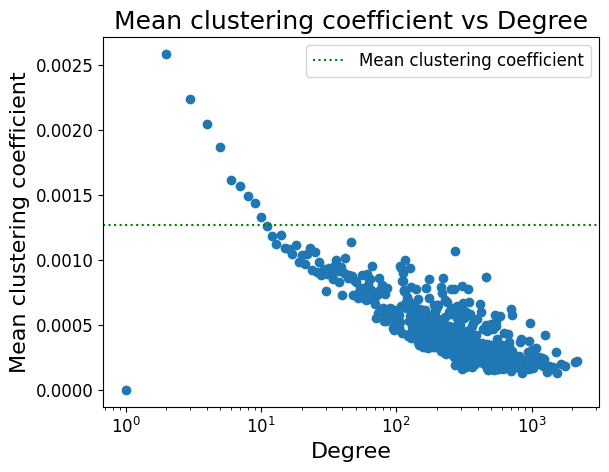

In [ ]:
# Plot mean_coef_for_degree
plt.scatter(mean_coef_for_degree.keys(), mean_coef_for_degree.values())
plt.axhline(y = mean_clus_coef, color = 'g', linestyle = ':', label = 'Mean clustering coefficient')
plt.xlabel('Degree', fontsize = 16)
plt.ylabel('Mean clustering coefficient', fontsize = 16)
plt.title('Mean clustering coefficient vs Degree', fontsize = 18)
plt.legend(fontsize = 12)
# log
plt.xscale('log')
plt.tick_params(axis = 'both', labelsize = 12)
# save as svg
plt.savefig('clustering_coeff_vs_degree.svg', format='svg')
plt.show()

#### Clustering coefficient for unweighted graph

In [ ]:
# Mean cluster coefficient
mean_clus_coef_uw = nx.average_clustering(G_largest_cc)
print(f"Mean clustering coefficient: {mean_clus_coef_uw:.3f}")

# Cluster coefficients
cluster_coeffs_uw = nx.clustering(G_largest_cc)

# Compute mean clustering coefficient for nodes grouped by their degree
# Initialize empty dictionary
mean_coef_for_degree_uw = {}
# Iterate over each node in cluster_coeffs
for node in cluster_coeffs_uw:
  # Get the node degree
  deg = G_largest_cc.degree(node)
  # Checks if the degree is already in the dictionary
  if deg in mean_coef_for_degree_uw:
    # If so, append the clustering coefficient of the current node
    # to the list associated with that degree
    mean_coef_for_degree_uw[deg].append(cluster_coeffs_uw[node])
  else:
    # If not, create a new key and initialize the value as a list
    # containing the clustering coefficient of the current node
    mean_coef_for_degree_uw[deg] = [cluster_coeffs_uw[node]]

# Compute the mean clustering coefficient for each degree
# Iterate over each degree in mean_coef_for_degree
for deg in mean_coef_for_degree_uw:
  # Compute the mean clustering coefficient for all nodes with the current degree
  mean_coef_for_degree_uw[deg] = sum(mean_coef_for_degree_uw[deg])/len(mean_coef_for_degree_uw[deg])

Mean clustering coefficient: 0.310


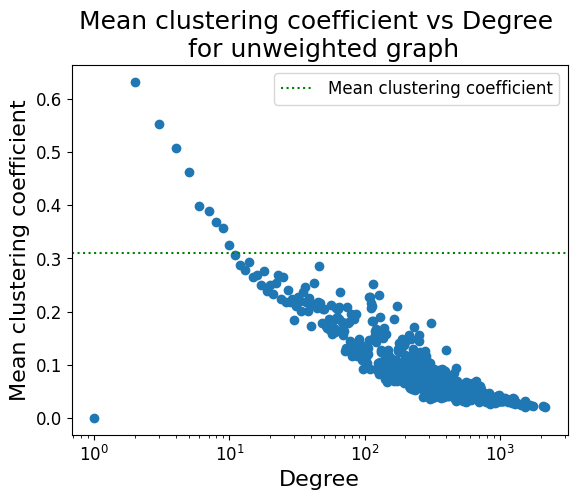

In [ ]:
# plot mean_coef_for_degree
plt.scatter(mean_coef_for_degree_uw.keys(), mean_coef_for_degree_uw.values())
plt.axhline(y = mean_clus_coef_uw, color = 'g', linestyle = ':', label = 'Mean clustering coefficient')
plt.xlabel('Degree', fontsize = 16)
plt.ylabel('Mean clustering coefficient', fontsize = 16)
plt.title('Mean clustering coefficient vs Degree \n for unweighted graph', fontsize = 18)
plt.legend(fontsize = 12)
# log
plt.xscale('log')
plt.tick_params(axis = 'both', labelsize = 12)
# save as svg
plt.savefig('clustering_coeff_vs_degree_uw.svg', format = 'svg')
plt.show()

## Partitioning
#####In this section, we will focus on identifying communities based on groupings of dataset characteristics such as main category, sub-category and store. This analysis serves as a preliminary step to estimate the coverage of reviews and assess user satisfaction within the identified communities, as well as to figure out the most common and meaningful words in the reviews using TF-IDF. Furthermore, we will compare these communities with those identified by the Louvain algorithm, using modularity as the basis for comparison.

The $\texttt{calculate_modularity}$ function computes the modularity as described in equation 9.12 in the Network Science book, and it's reused from assignment 2.

In [ ]:
def calculate_modularity(graph, communities):

    # Number of links
    L = graph.number_of_edges()
    # Counter for moduality
    Mc = 0

    # The partition’s modularity by summing over all nc communities
    for community in communities:
        # Total number of links within the community
        Lc = graph.subgraph(community).number_of_edges()
        # Total degree of the nodes in this community
        kc = sum(graph.degree[node] for node in community)
        # Update moduality (Mc)
        Mc += (Lc / L) - ((kc / (2 * L))**2)

    return Mc

Calculate the modularity for the network with the partion described above (based on the first category)

#### Create a partition where each node is assigned to a community based on its product main category, and calculate the modularity of the communities based on the product main category

In [ ]:
# Create dictionary where the keys are the product and
# the values are their associated main category
products_with_mainCategory =  dict(zip(meta_df['parent_asin'], meta_df['main_category']))

# Filter products_with_mainCategory to include only products in the graph
products_with_mainCategory = {k: v for k, v in products_with_mainCategory.items() if k in G.nodes()}

In [ ]:
# Create partition
mainCategory_dict = {node: products_with_mainCategory[node] for node in G.nodes()}

# Create empty dictionary
mainCategory_partition = {}
# Iterate over each node and their associated categories
for node, item_mainCategory in products_with_mainCategory.items():
    # Add node to the associated category
    # if the current category not a key, create it and add node
    mainCategory_partition.setdefault(item_mainCategory, []).append(node)
    # Assign genre as node attribute the graph
    nx.set_node_attributes(G, {node: {'main_category': item_mainCategory}})

In [ ]:
# Compute moduality
modularity = calculate_modularity(G, mainCategory_partition.values())
print(f"The modularity is: {modularity:.3f}")

The modularity is: 0.088


#### Create a partition where a node is assigned to a community if the product is within the top 10 main categories, and calculate the modularity of the communities

In [ ]:
# Count occurrences of each store with respect to products
# Select the top 10 main categories
top10_main_category = [main_category for main_category, _ in Counter(mainCategory_dict.values()).most_common(10)]

# Display the top 10 main categories
print("The top 10 main categories are:")
print(31*'-')

# Split the list into 3 roughly equal parts
num_rows = 10
split_lists = [top10_main_category[i::num_rows] for i in range(num_rows)]

# Define the width for each column
column_width = 30

# Print each row
for row in split_lists:
    print(' | '.join(maincategory.ljust(column_width) for maincategory in row))

The top 10 main categories are:
-------------------------------
Tools & Home Improvement      
Appliances                    
Amazon Home                   
Industrial & Scientific       
Automotive                    
Health & Personal Care        
All Electronics               
Grocery                       
Sports & Outdoors             
Baby                          


In [ ]:
# Create partition
top10_main_category_dict = {node: main_category for node, main_category in mainCategory_dict.items() if main_category in top10_main_category}

# Create empty dictionary
top10_main_category_partition = {}
# Iterate over each node and their associated categories
for node, item_main_category in top10_main_category_dict.items():
    # Add node to the associated category
    # if the current category not a key, create it and add node
    top10_main_category_partition.setdefault(item_main_category, []).append(node)
    # Assign genre as node attribute the graph
    nx.set_node_attributes(G, {node: {'top_main_category': item_main_category}})

In [ ]:
# Compute moduality
modularity = calculate_modularity(G, top10_main_category_partition.values())
print(f"The modularity is: {modularity:.3f}")

The modularity is: 0.088


#### Create a partition where each node is assigned to a community based on its product subcategory, and calculate the modularity of the communities based on the product subcategory

In [ ]:
# Create dictionary where the keys are the product and
# the values are their associated subcategory
products_with_subCategory =  dict(zip(meta_df['parent_asin'], meta_df['subCategory']))

In [ ]:
# Create partition
subCategory_dict = {node: products_with_subCategory[node] for node in G.nodes()}

# Create empty dictionary
subCategory_partition = {}
# Iterate over each node and their associated categories
for node, item_subCategory in subCategory_dict.items():
    # Add node to the associated category
    # if the current category not a key, create it and add node
    subCategory_partition.setdefault(item_subCategory, []).append(node)
    # Assign genre as node attribute the graph
    nx.set_node_attributes(G, {node: {'subCategory': item_subCategory}})

In [ ]:
# Compute moduality
modularity = calculate_modularity(G, subCategory_partition.values())
print(f"The modularity is: {modularity:.3f}")

The modularity is: 0.118


#### Create a partition where a node is assigned to a community if the product is within the top 10 subcategories, and calculate the modularity of the communities

In [ ]:
# Count occurrences of each store with respect to products
# Select the top 10 main categories
top10_sub_category = [sub_category for sub_category, _ in Counter(subCategory_dict.values()).most_common(10)]

# Display the top 10 main categories
print("The top 10 sub categories are:")
print(30*'-')

# Split the list into 3 roughly equal parts
num_rows = 10
split_lists = [top10_sub_category[i::num_rows] for i in range(num_rows)]

# Define the width for each column
column_width = 30

# Print each row
for row in split_lists:
    print(' | '.join(sub_category.ljust(column_width) for sub_category in row))

The top 10 sub categories are:
------------------------------
Parts & Accessories           
Replacement Parts             
Water Filters                 
Washer Parts & Accessories    
Ice Makers                    
Reusable Filters              
Accessories                   
Knobs                         
Refrigerators                 
Disposable Filters            


In [ ]:
# Create partition
top10_sub_category_dict = {node: sub_category for node, sub_category in subCategory_dict.items() if sub_category in top10_sub_category}

# Create empty dictionary
top10_sub_category_partition = {}
# Iterate over each node and their associated categories
for node, item_sub_category in top10_sub_category_dict.items():
    # Add node to the associated category
    # if the current category not a key, create it and add node
    top10_sub_category_partition.setdefault(item_sub_category, []).append(node)
    # Assign genre as node attribute the graph
    nx.set_node_attributes(G, {node: {'top_sub_category': item_sub_category}})

In [ ]:
# Compute moduality
modularity = calculate_modularity(G, top10_sub_category_partition.values())
print(f"The modularity is: {modularity:.3f}")

The modularity is: 0.093


#### Create a partition where each node is assigned to a community based on the store that sold the product, and calculate the modularity of the communities based on the store

In [ ]:
# Create dictionary where the keys are the product and
# the values are their associated store
products_with_store = dict(zip(meta_df['parent_asin'], meta_df['store']))

In [ ]:
# Create partition
store_dict = {node: products_with_store[node] for node in G.nodes()}

# Create empty dictionary
store_partition = {}
# Iterate over each node and their associated categories
for node, item_store in store_dict.items():
    # Add node to the associated category
    # if the current category not a key, create it and add node
    store_partition.setdefault(item_store, []).append(node)
    # Assign genre as node attribute the graph
    nx.set_node_attributes(G, {node: {'store': item_store}})

In [ ]:
# Compute moduality
modularity = calculate_modularity(G, store_partition.values())
print(f"The modularity is: {modularity:.3f}")

The modularity is: 0.053


#### Create a partition where a node is assigned to a community if the product is sold by one of the top 10 stores, and calculate the modularity of the communities based on the top 10 stores

In [ ]:
# Count occurrences of each store with respect to products
# Select the top 10 stores
top10_stores = [store for store, _ in Counter(store_dict.values()).most_common(10)]

# Display the top 10 stores
print("The top 10 stores are:")
print(22*'-')

# Split the list into 3 roughly equal parts
num_rows = 10
split_lists = [top10_stores[i::num_rows] for i in range(num_rows)]

# Define the width for each column
column_width = 20

# Print each row
for row in split_lists:
    print(' | '.join(store.ljust(column_width) for store in row))

The top 10 stores are:
----------------------
Whirlpool           
GE                  
FRIGIDAIRE          
SAMSUNG             
LG                  
Supplying Demand    
Edgewater Parts     
ERP                 
Frigidaire          
AMI PARTS           


In [ ]:
# Create partition
top10_store_dict = {node: store for node, store in store_dict.items() if store in top10_stores}

# Create empty dictionary
top10_store_partition = {}
# Iterate over each node and their associated categories
for node, item_store in top10_store_dict.items():
    # Add node to the associated category
    # if the current category not a key, create it and add node
    top10_store_partition.setdefault(item_store, []).append(node)
    # Assign genre as node attribute the graph
    nx.set_node_attributes(G, {node: {'top_store': item_store}})

In [ ]:
# Compute moduality
modularity = calculate_modularity(G, top10_store_partition.values())
print(f"The modularity is: {modularity:.3f}")

The modularity is: 0.037


#### Apply the Louvain algorithm to partition the nodes into communities, and calculate the modularity of the communities based on the partitions generated by the algorithm



In [ ]:
# Apply Louvain partitioning
partition = community_louvain.best_partition(G)

In [ ]:
# Create partition
# Create empty dictionary
community_partition = {}
# Iterate over each node and their associated commiunity
for node, community in partition.items():
    # Add node to the associated community
    # if the current community not a key, create it and add node
    community_partition.setdefault(community, []).append(node)
    # Assign community as node attribute the graph
    nx.set_node_attributes(G, {node: {'community': community}})

In [ ]:
# Compute moduality
modularity = calculate_modularity(G, community_partition.values())
print(f"The modularity is: {modularity:.3f}")

The modularity is: 0.357


#### Visualize the network with respect to the sub-category partition

100%|██████████| 100/100 [43:22<00:00, 26.02s/it]


BarnesHut Approximation  took  36.04  seconds
Repulsion forces  took  2560.11  seconds
Gravitational forces  took  0.35  seconds
Attraction forces  took  2.05  seconds
AdjustSpeedAndApplyForces step  took  1.68  seconds


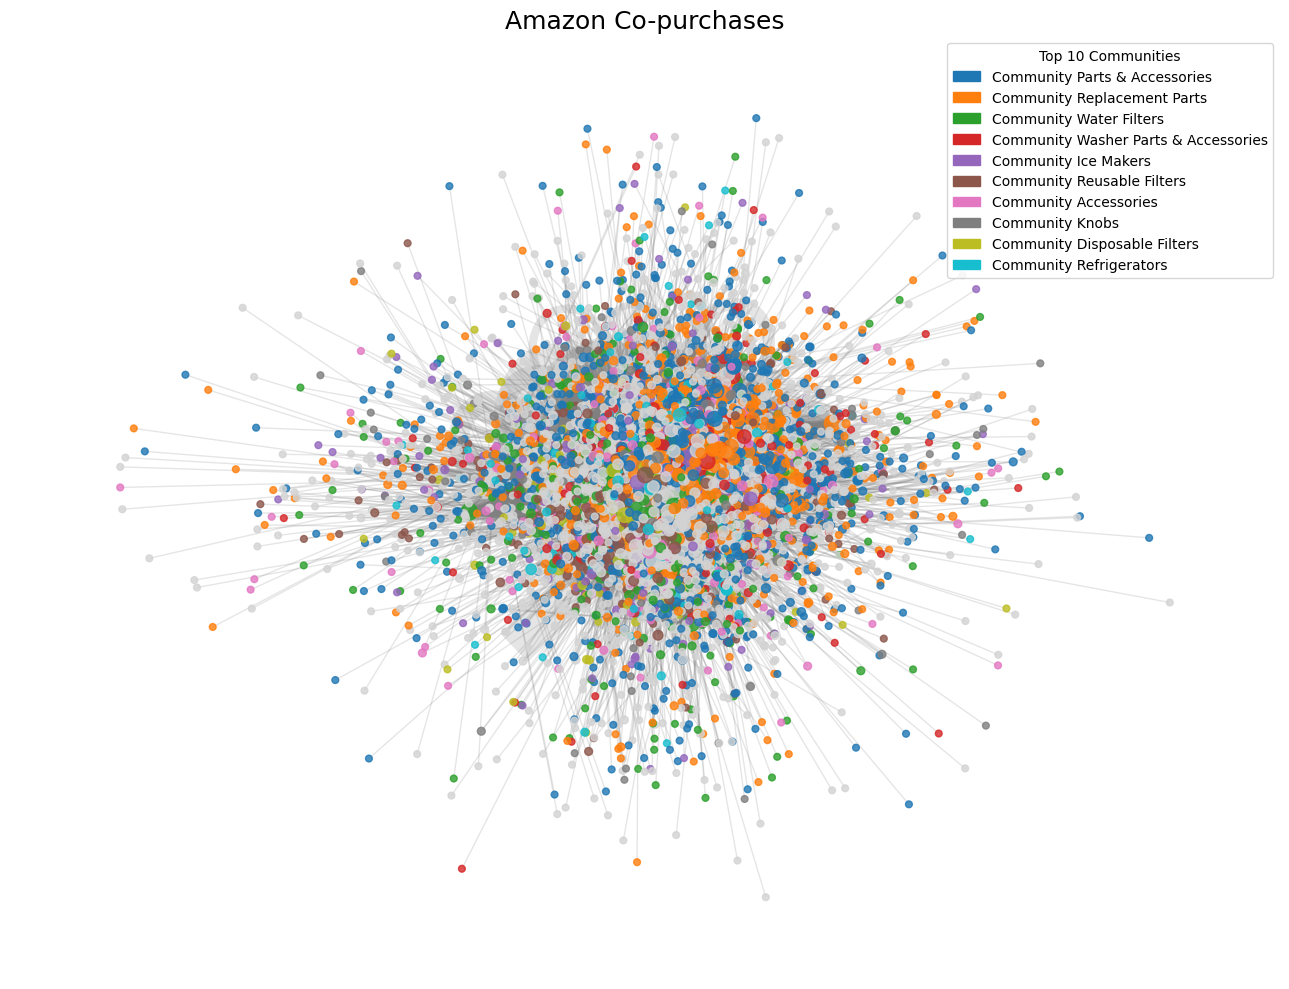

In [ ]:
# Extract the largest connected component
G_largest_cc = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# Initialize ForceAtlas2 and compute positions
# The parameters are found by trial and error
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1,
    jitterTolerance=0.5,
    barnesHutOptimize=True,
    barnesHutTheta=0.3,
    multiThreaded=False,
    scalingRatio=2.2,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True
)
positions = forceatlas2.forceatlas2_networkx_layout(G_largest_cc, iterations=100)

# Scale node sizes (log-transformed degree)
node_sizes = [10 + np.log(nx.degree(G_largest_cc, n) + 1) * 20 for n in G_largest_cc.nodes()]

# Get node communities based on 'subCategory'
node_communities = [G_largest_cc.nodes[n].get('subCategory', '') for n in G_largest_cc.nodes()]

# Count the frequency of each subCategory
subCategory_counts = Counter(node_communities)

# Identify the top 10 most frequent subCategories
top_10_subCategories = [subCategory for subCategory, _ in subCategory_counts.most_common(10)]

# Filter and map colors for the top 10 subCategories
subCategory_color_map = {subCategory: plt.cm.tab10(i) for i, subCategory in enumerate(top_10_subCategories)}

# Apply colors based on top 10 communities, fallback to gray for others
node_colors = [
    subCategory_color_map[community] if community in top_10_subCategories else "#d3d3d3"
    for community in node_communities
]

# Create legend patches only for top 10 subCategories
patches = [
    mpatches.Patch(color=subCategory_color_map[community], label=f'Community {community}')
    for community in top_10_subCategories
]

# Visualize the network
plt.figure(figsize=(13, 10))

# Draw nodes with updated sizes and colors
nx.draw_networkx_nodes(
    G_largest_cc, positions, node_size=node_sizes, node_color=node_colors, alpha=0.8
)

# Draw edges with appropriate alpha and width
edge_weights = [G_largest_cc[u][v].get('weight', 1) for u, v in G_largest_cc.edges()]
nx.draw_networkx_edges(
    G_largest_cc, positions, edge_color="gray", alpha=0.2, width=edge_weights
)

# Add legend for the top 10 communities
plt.legend(handles=patches, title="Top 10 Communities", loc="upper right")

# Final adjustments
plt.axis("off")
plt.title("Amazon Co-purchases", fontsize=18)
plt.tight_layout()
plt.savefig("amazon_network_top10_1.svg", format="svg")
plt.show()

The network features densely clustered nodes at its center, despite the parameter \texttt{scalingRatio = 2.2}, indicating a high concentration of connections where nodes are closely packed together. As you move outward from the center, the nodes progressively disperse towards the edges, reflecting a decrease in connectivity and a more sparse arrangement of nodes. This structure suggests that the central region serves as a hub of high activity or interaction, while the peripheral areas represent less connected or more isolated nodes.


Only the top ten communities are colored due to the large number of sub-categories. It's noticible that the "Replacement Parts" community is centered in the center towards the upper right corner, while the "Reusable filters" community is centered towards the lower left corner. The "Water filters" community is a bit more to the left side while the "Parts & Accessories" community is all over the place, so is the "Ice Makers" and "Accessories" community.

The strong links between nodes from different communities suggests co-purchase relationships across product categories. Nodes in the center likely have higher degree centrality, representing products that are frequently co-purchased across categories.

#### Visualize the network with respect to the Louvain partition

100%|██████████| 100/100 [41:21<00:00, 24.81s/it]


BarnesHut Approximation  took  38.49  seconds
Repulsion forces  took  2437.18  seconds
Gravitational forces  took  0.41  seconds
Attraction forces  took  1.84  seconds
AdjustSpeedAndApplyForces step  took  1.62  seconds


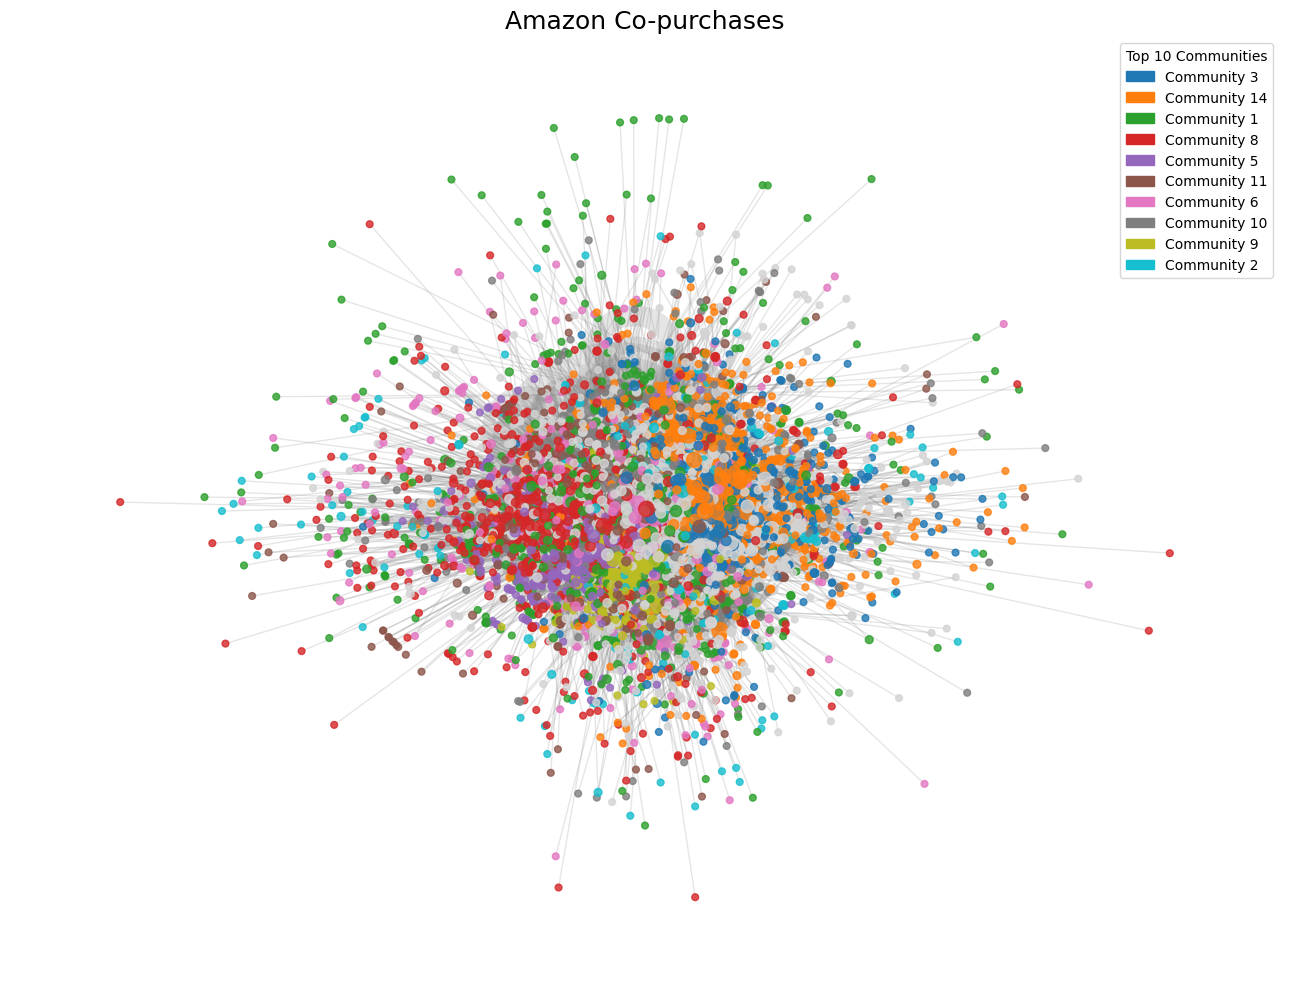

In [ ]:
# Extract the largest connected component
G_largest_cc = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# Initialize ForceAtlas2 and compute positions
# The parameters are found by trial and error
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1,
    jitterTolerance=0.5,
    barnesHutOptimize=True,
    barnesHutTheta=0.3,
    multiThreaded=False,
    scalingRatio=2.2,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True
)
positions = forceatlas2.forceatlas2_networkx_layout(G_largest_cc, iterations=100)

# Scale node sizes (log-transformed degree)
node_sizes = [10 + np.log(nx.degree(G_largest_cc, n) + 1) * 20 for n in G_largest_cc.nodes()]

# Get node communities based on Louvain community
node_communities = [G_largest_cc.nodes[n].get('community', '') for n in G_largest_cc.nodes()]

# Count the frequency of each Louvain_community
Louvain_community_counts = Counter(node_communities)

# Identify the top 10 most frequent Louvain_community
top_10_Louvain_community = [Louvain_community for Louvain_community, _ in Louvain_community_counts.most_common(10)]

# Filter and map colors for the top 10 Louvain_community
Louvain_community_color_map = {Louvain_community: plt.cm.tab10(i) for i, Louvain_community in enumerate(top_10_Louvain_community)}

# Apply colors based on top 10 communities, fallback to gray for others
node_colors = [
    Louvain_community_color_map[community] if community in top_10_Louvain_community else "#d3d3d3"
    for community in node_communities
]

# Create legend patches only for top 10 Louvain_community
patches = [
    mpatches.Patch(color=Louvain_community_color_map[community], label=f'Community {community}')
    for community in top_10_Louvain_community
]

# Visualize the network
plt.figure(figsize=(13, 10))

# Draw nodes with updated sizes and colors
nx.draw_networkx_nodes(
    G_largest_cc, positions, node_size=node_sizes, node_color=node_colors, alpha=0.8
)

# Draw edges with appropriate alpha and width
edge_weights = [G_largest_cc[u][v].get('weight', 1) for u, v in G_largest_cc.edges()]
nx.draw_networkx_edges(
    G_largest_cc, positions, edge_color="gray", alpha=0.2, width=edge_weights
)

# Add legend for the top 10 communities
plt.legend(handles=patches, title="Top 10 Communities", loc="upper right")

# Final adjustments
plt.axis("off")
plt.title("Amazon Co-purchases", fontsize=18)
plt.tight_layout()
plt.savefig("amazon_network_top10_louvain.svg", format="svg")
plt.show()

The graph exhibits densely clustered nodes at its center, where nodes from various communities are closely packed together. This suggests that nodes from different communities are highly interconnected. This indicates that products belonging to different categories often share links, highlighting strong interactions between communities in the central hub of the network.

Only the top ten communities are colored for simplicity. Community 8 is pretty distinct at the left side, while community 14 and 3 are on the right side. Then community 9 is lower centrally placed, while community 5 is placed between 8 and 9. However, community 1, 2 and 6 are all over the place. Dominant communities (e.g., community 3, 14, and 1) occupy significant portions of the graph, indicating groups of nodes (products) that are often co-purchased.

The more distinct clusters shows when applying the Louvain algorithm demonstrates the strength of modularity optimization, which is also reflected by the moduality scores.

## Text analysis

The purpose of the $\texttt{clean_text}$ function is to process the lists of text data in the reviews. It removes unwanted elements like URLs, [[ ]], extra whitespace, punctuations, stop words, converts all letters to lowercase and returns the concatenated cleaned version of the text.

In [ ]:
def clean_text(texts):

    # Initialize empty string to store the final cleaned texts
    clean_result = ""
    # Load english stop words
    stop_words = set(stopwords.words("english"))

    # Iterate over each review
    for text in texts:

      # Remove any URLs left in the text
      text = re.sub(r"http\S+|www\S+|https\S+", "", text)

      # Replace HTML line break tags with a space
      text = text.replace('<br />', ' ').replace('<br/>', ' ')

      # Remove [[]]
      text = re.sub(r'\[\[.*?\]\]', '', text)

      # Remove punctuation
      text = re.sub(r'[^\w\s]', '', text)

      # Remove all words with numbers in them
      text = re.sub(r'\b\w*\d\w*\b', '', text)

      # Remove extra whitespace
      text = re.sub(r'\s+', ' ', text)

      # Change letters to lowercase and remove stop words
      cleaned_words = [word.lower() for word in text.split() if word.lower() not in stop_words]

      # Join the cleaned words into a string, separated by spaces
      cleaned_text = " ".join(cleaned_words)

      # Append the text to clean_result
      clean_result += cleaned_text + " "

    return clean_result

The purpose of the $\texttt{calculate_log_tf}$ function is to compute a log-normalized term frequency (TF) for the words in text data grouped by communities. It processes the text for each group, tokenizes it, removes infrequent words, and applies a logarithmic transformation to the word frequencies.

In [ ]:
def calculate_log_tf(texts, limit = 5):
  """
  Function to get the log normalized term frequency of each group in the texts dictionary

  - texts: dictionary, keys are groups (genre or community), item is a single string
  - limit: number of minimum occurences of a word to be included in term-frequency
  """

  # Initialize an empty dictionary to store term frequency for each group
  tf = {}

  # Iterate over each group and its associated text data
  for group, products in texts.items():

      # Print the group name
      print(group)

      # Initialize a counter to keep track of word counts for the current group
      group_counter = Counter()

      # Iterate over the list of text strings in the current group
      for text in tqdm(products):
        # Tokenize the string
        tokens = word_tokenize(text)
        # Count the occurrences of each token in the text
        word_counts = Counter(tokens)
        # Update the group's word counter with the current text's word counts
        group_counter.update(word_counts)

      # Apply log normalization to the word frequencies in the group's counter
      for w in group_counter:
          group_counter[w] = 1 + math.log(group_counter[w])

      # Save TF
      tf[group] = group_counter

  return tf

The purpose of the $\texttt{calculate_idf}$ function is to compute the Inverse Document Frequency (IDF) for each word in text data grouped by communities. IDF is a measure of how important a word is across multiple groups. Words that appear in many groups are given lower importance, while words that appear in fewer groups are given higher importance.

In [ ]:
def calculate_idf(tf):

  # Initialize the empty dictionary
  idf = {}

  # Iterate over groups
  for group1 in tf:
      # Initialize a sub-dictionary for the group's IDF values
      idf[group1] = {}

      # Iterate over each word in the current group's term frequency dictionary
      for word in tf[group1]:
          # Initialize counter to keep track of how many groups contain the word
          idf_c = 0

          # Iterate over each word in the other group
          for group2 in tf:
              # Check if the word is in the other group's term frequency dictionary
              if word in tf[group2]:
                  # If the word is in the other group, increment the counter
                  idf_c += 1

          # Compute IDF score
          idf[group1][word] = math.log(len(tf)/idf_c)

  return idf

#### Clean all review texts

We will first clean all review texts and save them in a long string for each product, so then all partitions can use this texts and we don't have to clean the same text several times.

In [ ]:
# Initialize an empty dictionary to store reviews grouped by product
review_dict = {}

# Iterate over each row in the review_df
for _, rev in tqdm(review_df.iterrows()):
    # Extract the parent ASIN from the current row
    prod = rev['parent_asin']

    # Check if the parent ASIN is not already in the dictionary
    if prod not in review_dict:
        # If not, initialize an empty list for this product
        review_dict[prod] = []

    # Append the current review text to the list corresponding to this product
    review_dict[prod].append(rev['text'])

565690it [01:00, 9362.45it/s] 


In [ ]:
# Iterate over each product in review_dict
for prod in tqdm(review_dict):
    # Clean the list of reviews associated with the current product using clean_text()
    # Replace the original list of reviews with the cleaned version
    review_dict[prod] = clean_text(review_dict[prod])

100%|██████████| 55747/55747 [00:42<00:00, 1317.52it/s]


In [ ]:
# Group the sub categories
sub_categories = meta_df['subCategory']
grouped_sub_categories = sub_categories.groupby(sub_categories).count()

In [ ]:
# Hash table mapping product id to meta_df index
node_to_idx = {node: idx for idx, node in enumerate(meta_df['parent_asin'])}

#### Louvaine partition
We will analyze the term frequency depending on the Louvaine partition of the product.

First, we group the clean review texts of each product into the louvain communities in a dictionary.

In [ ]:
# Initialize an empty dictionary to store reviews for each top 10 Louvain community
louvaine_revs = {}

# Identify the top 10 communities
top_communities = [community for community, _ in Counter(partition.values()).most_common(10)]

# Iterate over all product-review pairs in review_dict
for prod, text in tqdm(review_dict.items()):
    try:
        # Retrieve the community assigned to the current product
        part = partition[prod]
    except:
        # Skip the current product if it is not found in the partition dictionary
        continue

    # Check if the community of the current product in the top 10 communities
    if part in top_communities:
        # If not, initialize it with an empty list
        if part not in louvaine_revs:
            louvaine_revs[part] = []

        # Append the review text of the current product to the corresponding community
        louvaine_revs[part].append(text)

100%|██████████| 55747/55747 [00:00<00:00, 768383.49it/s]


Calculate the Term Frequency of all words and the Inverse Document Frequency of each word in each Louvain community.

In [ ]:
# Calculate the Term Frequency (TF) using a log-based TF calculation
tf_louvaine = calculate_log_tf(louvaine_revs)

# Calculate the Inverse Document Frequency (IDF)
idf_louvaine = calculate_idf(tf_louvaine)

1


100%|██████████| 3484/3484 [00:07<00:00, 461.81it/s] 


7


100%|██████████| 5707/5707 [00:08<00:00, 711.29it/s] 


14


100%|██████████| 3015/3015 [00:04<00:00, 678.35it/s] 


45


100%|██████████| 5267/5267 [00:04<00:00, 1161.05it/s]


3


100%|██████████| 10026/10026 [00:08<00:00, 1136.35it/s]


13


100%|██████████| 3115/3115 [00:02<00:00, 1263.84it/s]


6


100%|██████████| 2288/2288 [00:01<00:00, 1450.70it/s]


5


100%|██████████| 2886/2886 [00:01<00:00, 1534.40it/s]


4


100%|██████████| 2389/2389 [00:01<00:00, 1590.75it/s]


2


100%|██████████| 2773/2773 [00:02<00:00, 1177.85it/s]


Calculating the TF-IDF by multiplying the TF with the IDF for each word in each Louvain community to get the TF-IDF values.

In [ ]:
# Initialize an empty dictionary to store TF-IDF scores
tf_idf_louvaine = {}

# Iterate over each community in the TF dictionary
for part in tf_louvaine:
    # Initialize an empty dictionary for storing TF-IDF values for the current community
    tf_idf_louvaine[part] = {}

    # Iterate over each word in the TF dictionary in the current community
    for word in tf_louvaine[part]:
        # Check if the TF of the word is greater than 4
        # to reduce the number of misspelled words when calculating tf-idf
        if tf_louvaine[part][word] > 4:
            # Calculate the TF-IDF score by multiplying TF and IDF values for the word
            tf_idf_louvaine[part][word] = tf_louvaine[part][word] * idf_louvaine[part][word]

Display the top 10 words TF-IDF wise for the top 10 Louvain communities:

In [ ]:
# Display top 10 words for each community in 5 columns
print('Top 10 words for each community: \n')
print('-' * 127)

# Define column width and spacing
word_width = 16  # Width for the word
score_width = 6  # Width for the score
spacing = 1       # Additional spacing between columns
columns = 5       # Number of columns

# Split the top communities into chunks for display
chunks = [top_communities[i:i + columns] for i in range(0, len(top_communities), columns)]

# Iterate over each chunk of communities
for chunk in chunks:
    # Extract the top 10 words for each community in the current chunk
    top_words_per_community = [
        sorted(tf_idf_louvaine[part].items(), key=lambda x: x[1], reverse=True)[:10]
        for part in chunk
    ]

    # Print community headers
    headers = [f"Community {part}".ljust(word_width + score_width + spacing) for part in chunk]
    print(' | '.join(headers))
    print('-' * 127)

    # Print top 10 words vertically
    for i in range(10):
        row = []
        for words in top_words_per_community:
            if i < len(words):
                word, score = words[i]
                formatted_word = f"{word:<{word_width}} {score:>{score_width}.3f}"
            else:
              # Empty space if fewer words
                formatted_word = "".ljust(word_width + score_width)
            row.append(formatted_word)
        print(' | '.join(row))
    print('-' * 127)

Top 10 words for each community: 

-------------------------------------------------------------------------------------------------------------------------------
Community 3             | Community 7             | Community 45            | Community 1             | Community 13           
-------------------------------------------------------------------------------------------------------------------------------
thermofuse        7.771 | ezcup            16.575 | hauslane         10.283 | nina             13.614 | glacier           2.978
limiter           7.377 | kerig            12.974 | kleen             7.969 | giantex          12.586 | mullion           2.611
diode             6.972 | aero             12.883 | allure            7.332 | euhomy           12.085 | icepure           1.846
sd                6.853 | ecocarafe        12.612 | kucht             7.237 | kuppet           11.652 | jura              1.773
napco             6.790 | perculator       12.532 | reflector        

Display the word clouds for the top 10 Louvain communities:

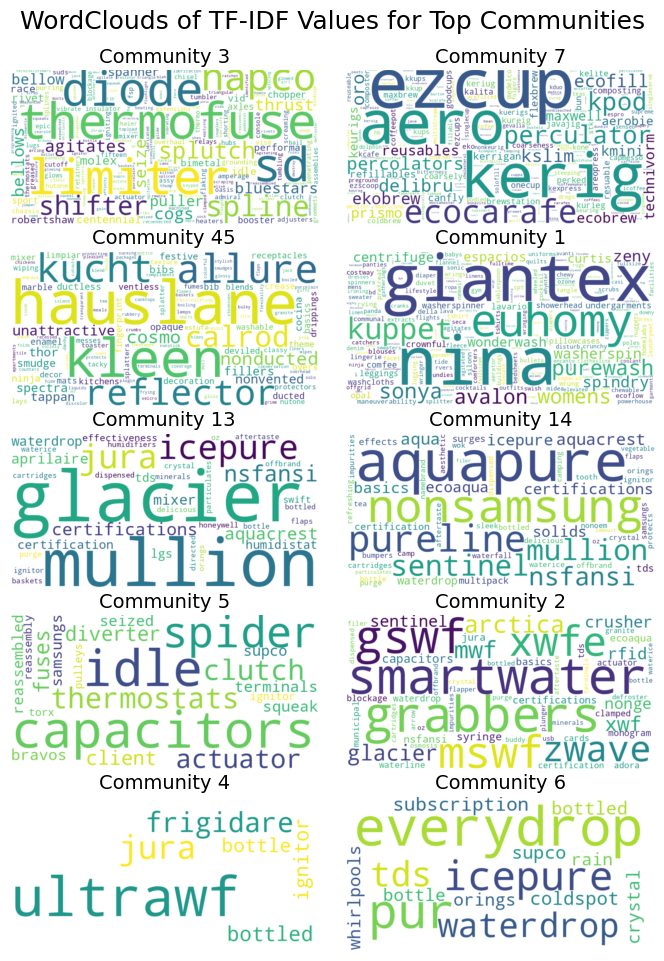

In [ ]:
# Set up the figure with 5 rows and 2 columns
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (7, 10))
fig.suptitle("WordClouds of TF-IDF Values for Top Communities", fontsize = 18, y = 0.97)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Generate and plot the WordCloud for each of the top 10 communities
for i, part in enumerate(top_communities[:10]):
    # Generate the WordCloud using TF-IDF values
    wordcloud = WordCloud(width = 800, height = 400, background_color = 'white', collocations = False)\
                    .generate_from_frequencies(tf_idf_louvaine[part])

    # Plot the WordCloud in the corresponding subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"Community {part}", fontsize=14)
    axes[i].axis("off")

# Hide unused subplots if any
for j in range(len(top_communities[:10]), len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing to reduce middle gap and make WordClouds bigger
# Reduce horizontal/vertical spacing
plt.subplots_adjust(wspace = 0.07, hspace = 0.07, top = 0.93)
plt.tight_layout(pad = 2)
plt.savefig("louvain_wordclouds.svg", format="svg")
plt.show()

#### Sub-categories
We will analyze the term frequency depending on the sub-categories of the product.

In [ ]:
# Convert the index of the grouped sub-categories into a list
sub_cats_grouped = grouped_sub_categories.index.tolist()

# Convert the values of the grouped sub-categories into a list
counts = grouped_sub_categories.values.tolist()

# Combine the sub-categories and their corresponding counts into a list of tuples
# Each tuple contains (category, count)
sub_cat_count = [(cat, count) for cat, count in zip(sub_cats_grouped, counts)]

# Sort the list of tuples by the count in descending order
sub_cat_count.sort(key=lambda x: x[1], reverse=True)

# Extract the top 10 sub-categories based on their counts
sub_categories_top = [x[0] for x in sub_cat_count[:10]]

We group the clean review texts of each product into the sub-categories in a dictionary.

In [ ]:
# Initialize an empty dictionary to store reviews for each sub-category
subcategory_revs = {}

# Iterate over all product-review pairs in the review_dict
for prod, text in tqdm(review_dict.items()):
    try:
        # Retrieve the sub-category for the current product using its index mapping
        cat = sub_categories[node_to_idx[prod]]
    except:
        # Skip the current product if it does not exist in the node_to_idx mapping
        continue

    # Check if the sub-category belongs to the list of top 10 sub-categories
    if cat in sub_categories_top:
        # If not yet in the dictionary, initialize it with an empty list
        if cat not in subcategory_revs:
            subcategory_revs[cat] = []

        # Append the review text to the list corresponding to the current sub-category
        subcategory_revs[cat].append(text)

100%|██████████| 55747/55747 [00:00<00:00, 129663.86it/s]


Calculate the Term Frequency of all words and the Inverse Document Frequency of each word in each sub-category.

In [ ]:
# Calculate the Term Frequency (TF) using a log-based TF calculation
tf_dict = calculate_log_tf(subcategory_revs)

# Calculate the Inverse Document Frequency (IDF)
idf_dict = calculate_idf(tf_dict)

Reusable Filters


100%|██████████| 2024/2024 [00:05<00:00, 384.80it/s] 


Water Filters


100%|██████████| 3338/3338 [00:06<00:00, 526.96it/s] 


Ice Makers


100%|██████████| 2104/2104 [00:03<00:00, 665.05it/s] 


Replacement Parts


100%|██████████| 9260/9260 [00:08<00:00, 1126.19it/s]


Accessories


100%|██████████| 1889/1889 [00:01<00:00, 1001.22it/s]


Refrigerators


100%|██████████| 1134/1134 [00:00<00:00, 1281.38it/s]


Parts & Accessories


100%|██████████| 10457/10457 [00:04<00:00, 2578.76it/s]


Washer Parts & Accessories


100%|██████████| 2328/2328 [00:01<00:00, 1528.49it/s]


Knobs


100%|██████████| 1277/1277 [00:00<00:00, 2030.92it/s]


Range Hoods


100%|██████████| 1094/1094 [00:02<00:00, 526.44it/s]


Calculating the TF-IDF by multiplying the TF with the IDF for each word in each sub-category to get the TF-IDF values.

In [ ]:
# Initialize an empty dictionary to store TF-IDF scores
tf_idf_dict = {}

# Iterate over each sub-category in the TF dictionary
for sub_category in tf_dict:
    # Initialize an empty dictionary for storing TF-IDF values for the current sub-category
    tf_idf_dict[sub_category] = {}

    # Iterate over each word in the TF dictionary in the current sub-category
    for word in tf_dict[sub_category]:
        # Check if the TF of the word is greater than 3
        # to reduce the number of misspelled words when calculating tf-idf
        if tf_dict[sub_category][word] > 3:
            # Calculate the TF-IDF score by multiplying TF and IDF values for the word
            tf_idf_dict[sub_category][word] = tf_dict[sub_category][word] * idf_dict[sub_category][word]

Display the top 10 words TF-IDF wise for the top 10 sub-categories:

In [ ]:
# Display top 10 words for each sub-category community in 5 columns
print('Top 10 words for each sub-category community:\n')
print('-' * 147)

# Define column width and spacing
word_width = 20  # Width for the word
score_width = 6  # Width for the score
spacing = 1      # Additional spacing between columns
columns = 5      # Number of columns

# Split the top sub-categories into chunks of 5 for display
chunks = [sub_categories_top[i:i + columns] for i in range(0, len(sub_categories_top), columns)]

# Iterate over each chunk of sub-categories
for chunk in chunks:
    # Extract the top 10 words for each sub-category in the current chunk
    top_words_per_subcategory = [
        sorted(tf_idf_dict[part].items(), key=lambda x: x[1], reverse=True)[:10]
        for part in chunk
    ]

    # Print sub-category headers
    headers = [f"{part}".ljust(word_width + score_width + spacing) for part in chunk]
    print(' | '.join(headers))
    print('-' * 147)

    # Print top 10 words vertically
    for i in range(10):  # Loop through 10 words
        row = []
        for words in top_words_per_subcategory:
            if i < len(words):
                word, score = words[i]
                formatted_word = f"{word:<{word_width}} {score:>{score_width}.3f}"
            else:
                # Empty space if fewer words
                formatted_word = "".ljust(word_width + score_width)
            row.append(formatted_word)
        print(' | '.join(row))
    print('-' * 147)


Top 10 words for each sub-category community:

---------------------------------------------------------------------------------------------------------------------------------------------------
Parts & Accessories         | Replacement Parts           | Water Filters               | Washer Parts & Accessories  | Ice Makers                 
---------------------------------------------------------------------------------------------------------------------------------------------------
compactor             8.307 | pulley               10.423 | rpwfe                12.860 | purewash             10.853 | newair               12.274
compactors            8.024 | idlers               10.134 | xwfe                 12.764 | agitator              7.636 | edgestar             11.612
silvercare            7.824 | napco                 9.805 | nsf                  12.087 | pavers                7.285 | crownful             11.310
fdr                   7.362 | idler                 9.485 | ecoaq

Display the word clouds for the top 10 sub-categories:

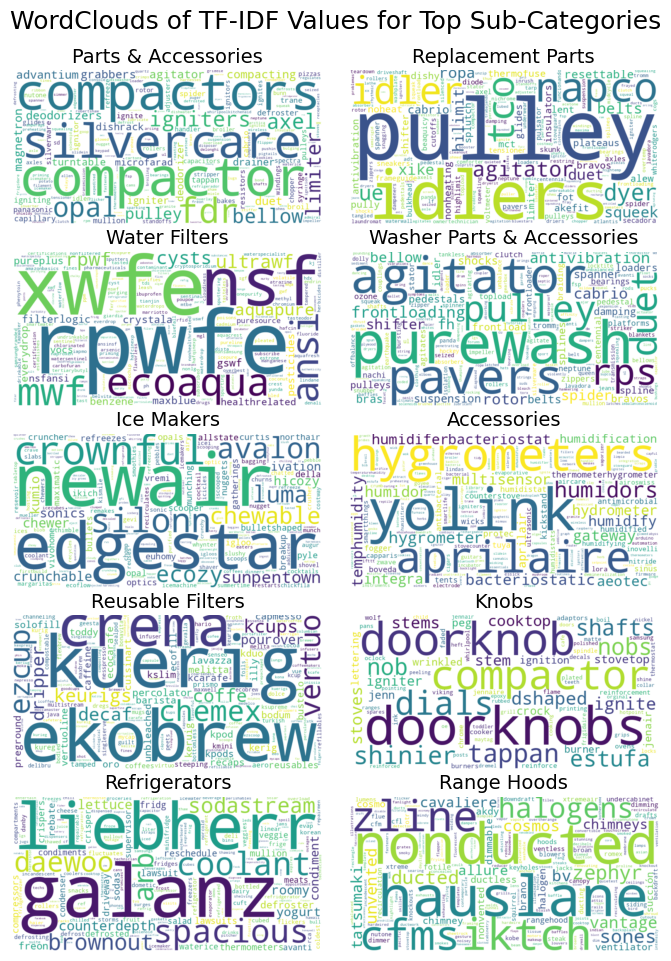

In [ ]:
# Set up the figure with 5 rows and 2 columns
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (7, 10))
fig.suptitle("WordClouds of TF-IDF Values for Top Sub-Categories", fontsize = 18, y = 0.97)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Generate and plot the WordCloud for each of the top 10 communities
for i, part in enumerate(sub_categories_top[:10]):
    # Generate the WordCloud using TF-IDF values
    wordcloud = WordCloud(width = 800, height = 400, background_color = 'white', collocations = False)\
                    .generate_from_frequencies(tf_idf_dict[part])

    # Plot the WordCloud in the corresponding subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"{part}", fontsize=14)
    axes[i].axis("off")

# Hide unused subplots if any
for j in range(len(sub_categories_top[:10]), len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing to reduce middle gap and make WordClouds bigger
# Reduce horizontal/vertical spacing
plt.subplots_adjust(wspace = 0.07, hspace = 0.07, top = 0.93)
plt.tight_layout(pad = 2)
plt.savefig("subcategories_wordclouds.svg", format="svg")
plt.show()

#### Comparison by confusion matrices

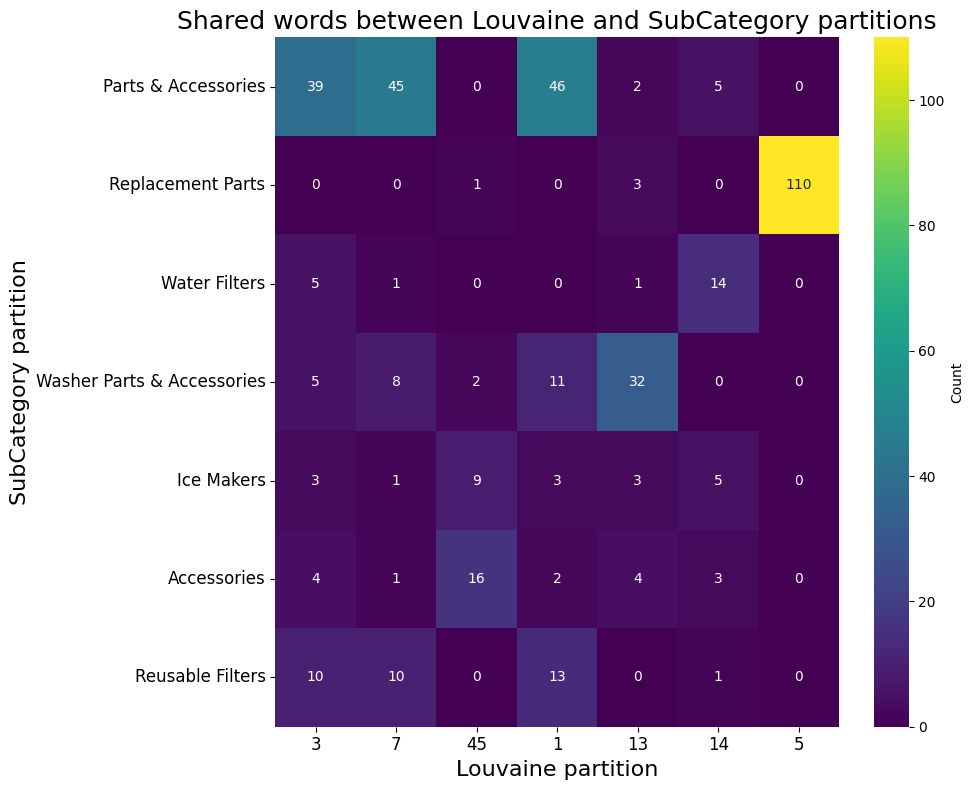

In [ ]:
# Matrix of louvaine vs subcategory shared words in top 200 tf-idf

# Ensure only the top 7 communities and sub-categories are considered
top_communities = top_communities[:7]
sub_categories_top = sub_categories_top[:7]

# Initialize a 7x7 matrix
X = np.zeros((7, 7), dtype=int)

# Iterate over the top 7 Louvain communities
for i, part in enumerate(top_communities):
    # Iterate over the top 7 sub-categories
    for j, part2 in enumerate(sub_categories_top):

        # Extract the top 200 words (based on TF-IDF values) for the current Louvain community
        # Sort words by their TF-IDF score in descending order
        list1 = [x[0] for x in sorted(tf_idf_louvaine[part].items(), key=lambda x: x[1], reverse=True)[:200]]

        # Extract the top 200 words (based on TF-IDF values) for the current sub-category
        # Sort words by their TF-IDF score in descending order
        list2 = [x[0] for x in sorted(tf_idf_dict[part2].items(), key=lambda x: x[1], reverse=True)[:200]]

        # Find the intersection of the two word lists
        shared_words = set(list1) & set(list2)

        # Store the number of shared words in the matrix
        X[i, j] = len(shared_words)

# Convert to a DataFrame for visualization
cm_df = pd.DataFrame(X, index = sub_categories_top, columns = top_communities)
cm_df.index.name = "SubCategory partition"
cm_df.columns.name = "Louvaine partition"

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot = True, fmt = "d", cmap = "viridis", cbar_kws = {'label': 'Count'})
plt.tick_params(axis = 'both', labelsize = 12)
plt.title("Shared words between Louvaine and SubCategory partitions", fontsize = 18)
plt.xlabel("Louvaine partition", fontsize = 16)
plt.ylabel("SubCategory partition", fontsize = 16)
plt.tight_layout()
# save svg
plt.savefig("shared_words.svg", format="svg")
plt.show()

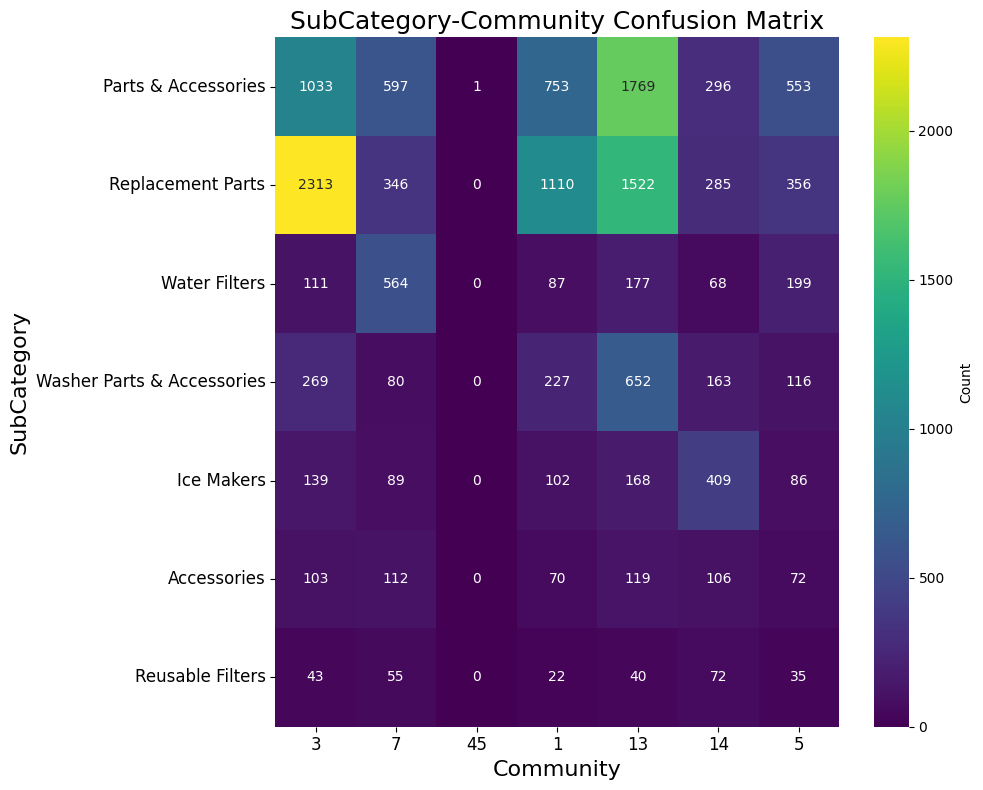

In [ ]:
# Matrix of the top 7 Louvaine partition vs subcategory

# Initialize 7x7 matrix
D = np.zeros((7, 7), dtype=int)

# Populate the matrix D
# Iterate over all nodes and their corresponding sub-categories
for node, subCategory in subCategory_dict.items():

    # Check if the current sub-category is in the list of top 7 sub-categories
    if subCategory in sub_categories_top:
        # Find the index of the sub-category in the top 7 sub-categories list
        subCategory_index = sub_categories_top.index(subCategory)

        # Retrieve the community to which the current node belongs to in the Louvain partition
        community = partition.get(node)

        # Check if the retrieved community is in the list of top 7 communities
        if community in top_communities:
            # Find the index of the community in the top 7 communities list
            community_index = top_communities.index(community)

            # Increment the corresponding cell in the matrix
            D[subCategory_index, community_index] += 1

# Convert to a DataFrame for visualization
confusion_matrix_df = pd.DataFrame(D, index=sub_categories_top, columns=top_communities)
confusion_matrix_df.index.name = "SubCategory"
confusion_matrix_df.columns.name = "Community"

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="viridis", cbar_kws={'label': 'Count'})
plt.xlabel("Community", fontsize = 16)
plt.ylabel("SubCategory", fontsize = 16)
plt.tick_params(axis = 'both', labelsize = 12)
plt.title("SubCategory-Community Confusion Matrix", fontsize = 18)
plt.tight_layout()
# save svg
plt.savefig("shared_communities.svg", format="svg")
plt.show()

### Sentiment Analysis

For the analysis, we apply the pretrained [Vader model](https://www.nltk.org/_modules/nltk/sentiment/vader.html) (Valence Aware Dictionary and sEntiment Reasoner) from the NLTK module.

The VADER is a lexicon and rule-based sentiment analysis tool. It calculates the sentiment of text by scoring words
as positive, negative, or neutral and considering punctuation, capitalization, negations, and degree modifiers (e.g.,
"very").

The compound score is a normalized value ranging from -1 (most negative) to +1 (most positive), representing the
overall sentiment polarity of the input text.

In [ ]:
# Initialize the Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Use lambda function to apply sentiment analysis
# The compound scores are extracted and stored a new column 'sentiment_score'
review_df.loc[:, 'sentiment_score'] = review_df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Assign sentiment type based on the compound score and stored a new column 'sentiment_type'
review_df.loc[:, 'sentiment_type'] = review_df['sentiment_score'].apply(lambda score: 'positive' if score > 0.05
                                                                        else ('negative' if score < -0.05 else 'neutral'))

<ipython-input-203-ca4d95661236>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df.loc[:, 'sentiment_score'] = review_df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
<ipython-input-203-ca4d95661236>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df.loc[:, 'sentiment_type'] = review_df['sentiment_score'].apply(lambda score: 'positive' if score > 0.05


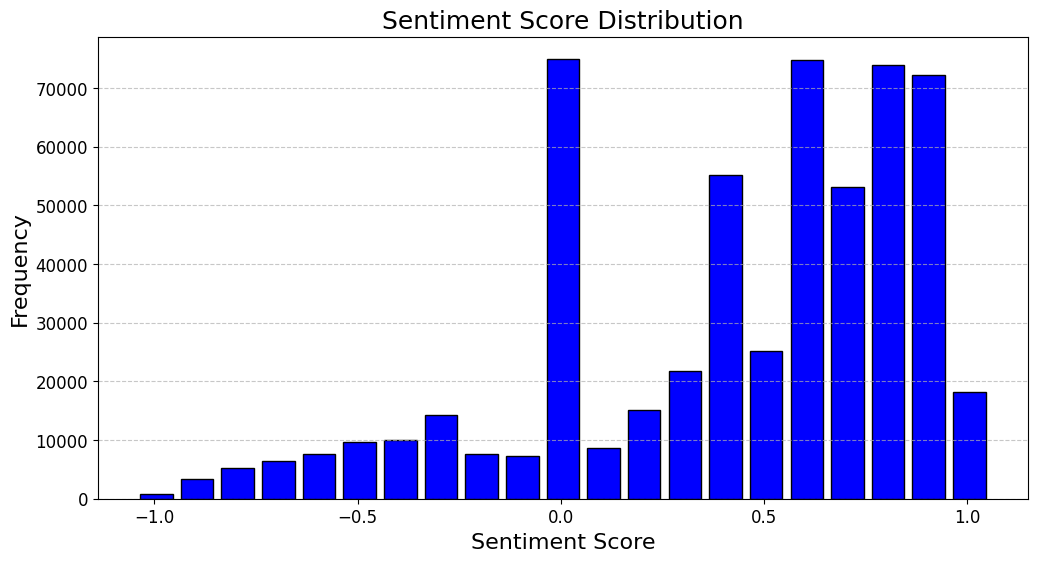

In [ ]:
# Define bins for histogram using arange
step_size = 0.1  # Adjust step size as needed
bins = np.arange(review_df['sentiment_score'].min()-0.05, review_df['sentiment_score'].max()+0.1, step_size)

# Compute histogram
counts, edges = np.histogram(review_df['sentiment_score'], bins = bins)

# Calculate midpoints of the bins
midpoints = edges[:-1] + 0.5 * (edges[1:] - edges[:-1])

# Plot the histogram
plt.figure(figsize = (12, 6))
plt.bar(midpoints, counts, width = 0.08, edgecolor='black', color='blue')
plt.title('Sentiment Score Distribution', fontsize = 18)
plt.xlabel('Sentiment Score', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tick_params(axis = 'both', labelsize = 12)
plt.savefig('sentiment_score_distribution.svg', format = 'svg')
plt.show()

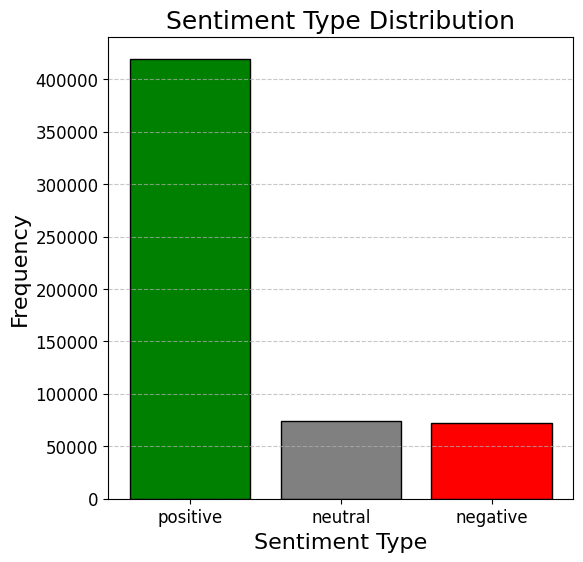

In [ ]:
# Count the occurrences of each sentiment type
sentiment_counts = review_df['sentiment_type'].value_counts()

# Plot the sentiment type distribution
plt.figure(figsize = (6, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, width = 0.8, color = ['green', 'gray', 'red'], edgecolor = 'black')
plt.title('Sentiment Type Distribution', fontsize = 18)
plt.xlabel('Sentiment Type', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tick_params(axis = 'both', labelsize = 12)
plt.savefig('sentiment_type_distribution.svg', format='svg')
plt.show()

#### Calculate the the average sentiment score for each product

In [ ]:
# Group products and their sentiment scores
products_with_avg_sentiment_score = review_df.groupby('parent_asin')['sentiment_score'].apply(list).reset_index()

# Compute average sentiment score
products_with_avg_sentiment_score['avg_sentiment_score'] = products_with_avg_sentiment_score['sentiment_score'].apply(lambda x: np.mean(x))

# Display dataframe example
products_with_avg_sentiment_score.head()

parent_asin                                    sentiment_score  \
0  0967805929    [0.4404, 0.807, 0.8585, 0.4926, 0.3804, 0.8217]   
1  1508810133                                           [0.4404]   
2  1563834103                                           [0.7351]   
3  1926644743  [0.7639, 0.6369, -0.3491, 0.7482, 0.3078, 0.66...   
4  B00002N7HY              [0.4215, 0.4404, 0.6249, 0.6249, 0.0]   

   avg_sentiment_score  
0             0.633433  
1             0.440400  
2             0.735100  
3             0.450530  
4             0.422340

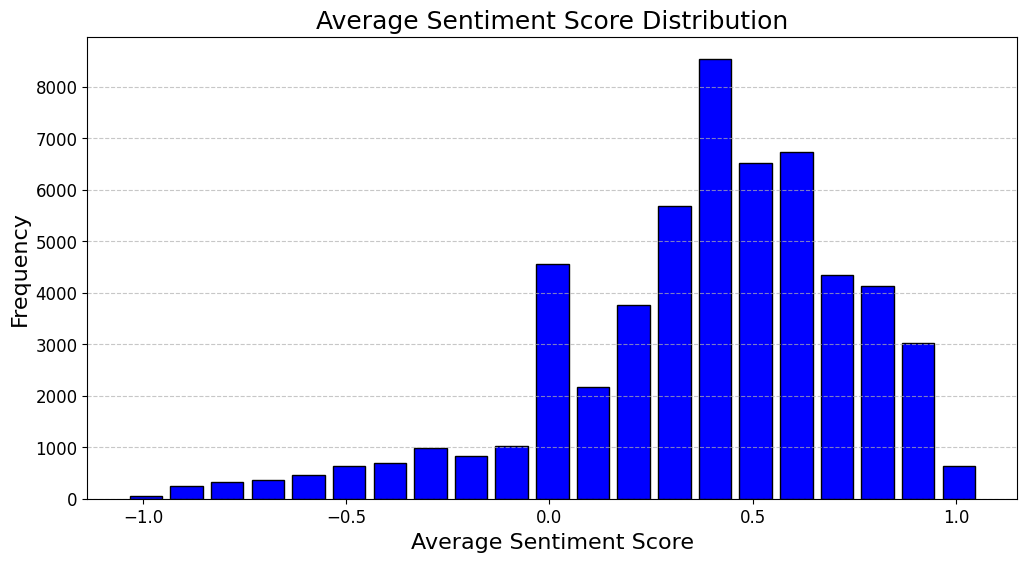

In [ ]:
# Define bins for histogram using arange
step_size = 0.1
bins = np.arange(products_with_avg_sentiment_score['avg_sentiment_score'].min()-0.05, products_with_avg_sentiment_score['avg_sentiment_score'].max()+0.1, step_size)

# Compute histogram
counts, edges = np.histogram(products_with_avg_sentiment_score['avg_sentiment_score'], bins = bins)

# Calculate midpoints of the bins
midpoints = edges[:-1] + 0.5 * (edges[1:] - edges[:-1])

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(midpoints, counts, width = 0.08, edgecolor='black', color='blue')
plt.title('Average Sentiment Score Distribution', fontsize = 18)
plt.xlabel('Average Sentiment Score', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.grid(axis='y', linestyle='--', alpha = 0.7)
plt.tick_params(axis='both', labelsize = 12)
plt.savefig('avg_sentiment_score_distribution.svg', format='svg')

The average sentiment scores are predominently neutral and positive

#### Assign the sentiment score as attribute to the nodes (product)

In [ ]:
# Create a dictionary where the keys are products
# and the values are their corresponding average sentiment scores
products_with_avg_sentiment_dict = dict(zip(products_with_avg_sentiment_score['parent_asin'], products_with_avg_sentiment_score['avg_sentiment_score']))

In [ ]:
# Create a list containing all nodes (products) in the graph
copurchased_products = [node for node in G]

# Initialize a dictionary where each product is a key and all values are empty strings
copurchased_products_with_sentiment = dict.fromkeys(copurchased_products, '')

# Iterate over each product in the dictionary
for product in copurchased_products_with_sentiment:
  # Check if the product exists in the dictionary with average sentiment scores
  if product in products_with_avg_sentiment_dict.keys():
    # If so, assign its average sentiment score to the dictionary
    copurchased_products_with_sentiment[product] = products_with_avg_sentiment_dict[product]
  else:
    # If not, assign 0 as the sentiment score
    copurchased_products_with_sentiment[product] = 0

In [ ]:
# Iterate over each product and its' corresponding sentiment score
for product, sentiment in copurchased_products_with_sentiment.items():
  # Assign sentiment score as a node attribute to the graph
  nx.set_node_attributes(G, {product: {'overall_sentiment': sentiment}})

#### Compute simple statistics for the sentiment scores across all reviews

In [ ]:
# Mean (mu)
average = np.mean(list(copurchased_products_with_sentiment.values()))
# Variance (sigma)
variance = np.var((list(copurchased_products_with_sentiment.values())))
# Median (Q2)
median = np.median(list(copurchased_products_with_sentiment.values()))

# 25th percentile (Q1)
percentile_25 = np.percentile((list(copurchased_products_with_sentiment.values())), 25)
# 75th percentile (Q3)
percentile_75 = np.percentile((list(copurchased_products_with_sentiment.values())), 75)

# Display the statistics
print(f"The average of the sentiment value for the co-purchased products is: {average:.3f}")
print(f"The variance of the sentiment value for the co-purchased products is: {variance:.3f}")
print(f"The median of the sentiment value for the co-purchased products is: {median:.3f} \n")

print(f"The 25th percentile of the sentiment value for the co-purchased products is: {percentile_25:.3f}")
print(f"The 75th percentile of the sentiment value for the co-purchased products is: {percentile_75:.3f} \n")

print(f"The minimum value of the sentiment is: {min(copurchased_products_with_sentiment.values()):.3f}")
print(f"The maximum value of the sentiment is: {max(copurchased_products_with_sentiment.values()):.3f}")

The average of the sentiment value for the co-purchased products is: 0.381
The variance of the sentiment value for the co-purchased products is: 0.132
The median of the sentiment value for the co-purchased products is: 0.436 

The 25th percentile of the sentiment value for the co-purchased products is: 0.203
The 75th percentile of the sentiment value for the co-purchased products is: 0.625 

The minimum value of the sentiment is: -0.993
The maximum value of the sentiment is: 1.000


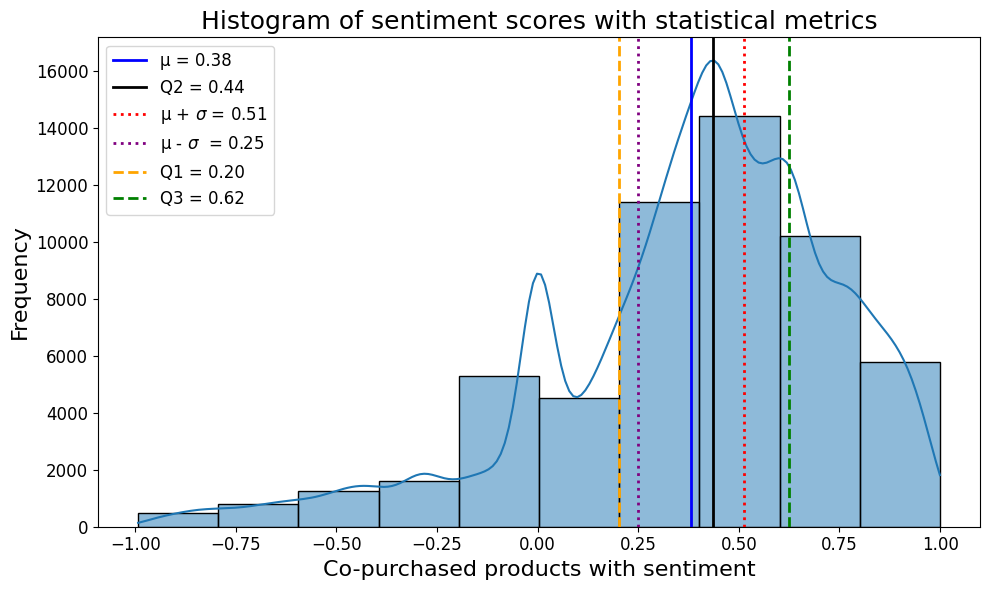

In [ ]:
# Plot histogram with statistics
# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(copurchased_products_with_sentiment.values(), bins=10, color="skyblue", kde=True)

# Plot mean
plt.axvline(average, color="blue", linestyle='-', linewidth=2)

# Plot median
plt.axvline(median, color="black", linestyle='-', linewidth=2)

# Plot variance boundaries (mean ± variance)
plt.axvline(average + variance, color="red", linestyle=':', linewidth=2, label=f'μ + Variance = {average + variance:.2f}')
plt.axvline(average - variance, color="purple", linestyle=':', linewidth=2, label=f'μ - Variance = {average - variance:.2f}')

# Plot 25th and 75th percentiles
plt.axvline(percentile_25, color="orange", linestyle='--', linewidth=2)
plt.axvline(percentile_75, color="green", linestyle='--', linewidth=2)

# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='blue', linestyle='-', linewidth=2, label=fr'μ = {average:.2f}'),
    Line2D([0], [0], color='black', linestyle='-', linewidth=2, label=fr'Q2 = {median:.2f}'),
    Line2D([0], [0], color='red', linestyle=':', linewidth=2, label=f'μ + $\sigma$ = {average + variance:.2f}'),
    Line2D([0], [0], color='purple', linestyle=':', linewidth=2, label=f'μ - $\sigma$  = {average - variance:.2f}'),
    Line2D([0], [0], color='orange', linestyle='--', linewidth=2, label=f'Q1 = {percentile_25:.2f}'),
    Line2D([0], [0], color='green', linestyle='--', linewidth=2, label=f'Q3 = {percentile_75:.2f}')
]

# Add custom legend to the plot
plt.legend(handles=legend_elements, loc="upper left", fontsize = 12)

# Labels and title
plt.xlabel('Co-purchased products with sentiment', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', labelsize = 12)
plt.title("Histogram of sentiment scores with statistical metrics", fontsize = 18)
plt.tight_layout()
plt.savefig('histogram_with_statistcs.svg', format='svg')
plt.show()


It is seen that the histogram follow a skewed to right distribution with a mean = 0.381 and a median = 0.436 and with a very low variance of 0.132.  All scores fall between -1 and 1. This means that most of the reviews for the co-purchased products are  predominantly slightly or normal positive. This is not surprising as the customers seems to satisfied but not totally impressed by the products purchased.

#### Calculate the Average Sentiment Scores for the Main Categories

In [ ]:
# Initialize an empty dictionary to store average sentiment scores for each category
main_category_partition_with_sentiment = {}

# Iterate over each main category and its associated list of products
for category, product_list in mainCategory_partition.items():
    # Retrieve sentiment scores for products in this category
    sentiment_scores = [products_with_avg_sentiment_dict[product] for product in product_list if product in products_with_avg_sentiment_dict]

    # Calculate the average sentiment score for the category
    if sentiment_scores!=0:  # Avoid division by zero
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    else:
        average_sentiment = 0  # Or set to 0 or another default value if no sentiment data is available

    # Assign the average sentiment to the category
    main_category_partition_with_sentiment[category] = average_sentiment

In [ ]:
# Display the average sentiment scores for the main categories
# Define column width
column_width = 33
# Print the header
print(f"{'Category'.ljust(column_width)}{'avg score'}")
print(42 * '-')

# Print each key-value pair formatted
for category, value in main_category_partition_with_sentiment.items():
    print(f"{category.ljust(column_width)}{value:.3f}")

Category                         avg score
------------------------------------------
Industrial & Scientific          0.358
Tools & Home Improvement         0.374
Appliances                       0.376
Amazon Home                      0.417
Computers                        0.488
AMAZON FASHION                   0.374
Automotive                       0.376
Camera & Photo                   0.444
Arts, Crafts & Sewing            0.238
Cell Phones & Accessories        0.436
Sports & Outdoors                0.281
Health & Personal Care           0.400
Musical Instruments              0.407
All Electronics                  0.359
All Beauty                       0.451
Grocery                          0.426
Office Products                  0.459
Baby                             0.434
Toys & Games                     0.379
GPS & Navigation                 0.977
Pet Supplies                     0.481
Home Audio & Theater             0.330
Video Games                      -0.669
Portable Audio &

In [ ]:
# Extract values
values = list(main_category_partition_with_sentiment.values())

# Calculate summary statistics
summary = {
    'Count': len(values),
    'Mean': np.mean(values),
    'Median': np.median(values),
    'Min': np.min(values),
    'Max': np.max(values),
    'Variance': np.var(values),
    'Std': np.std(values),
    'Sum': np.sum(values)
}

# Define column width
column_width = 13
# Print the header
print(f"{'Metric'.ljust(column_width)}{'value'}")
print(19 * '-')

# Print summary statistics
for key, value in summary.items():
    print(f"{key.ljust(column_width)}{value:.3f}")

Metric       value
-------------------
Count        27.000
Mean         0.378
Median       0.400
Min          -0.669
Max          0.977
Variance     0.059
Std          0.242
Sum          10.200


The sentiment analysis across communities, derived from partitioning based on the main category, reveals a
distribution with significant variance. The mean sentiment score of 0.378 suggests a moderate positive sentiment
overall. However, the standard deviation of 0.247 indicates considerable dispersion, reflecting diverse emotional
tones across the communities. The minimum score of -0.669 and maximum score of 0.977 highlight the presence
of both highly negative and highly positive sentiments within the dataset. The interquartile range, between the 25th
percentile (0.359) and 75th percentile (0.447), shows that the majority of communities exhibit sentiment scores
within a moderate positive range.

This analysis underscores the heterogeneity in sentiment, with communities
exhibiting both extreme negative and positive sentiments alongside more neutral to positive values.

#### Calculate the Average Sentiment Scores for the top 10 Main Categories

In [ ]:
# Initialize an empty dictionary to store average sentiment scores for each category
top10_main_category_partition_with_sentiment = {}

# Iterate over each main category in top 10 and its associated list of products
for category, product_list in top10_main_category_partition.items():
    # Retrieve sentiment scores for products in this category
    sentiment_scores = [products_with_avg_sentiment_dict[product] for product in product_list if product in products_with_avg_sentiment_dict]

    # Calculate the average sentiment score for the category
    if sentiment_scores!=0:  # Avoid division by zero
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    else:
        average_sentiment = 0  # Or set to 0 or another default value if no sentiment data is available

    # Assign the average sentiment to the category
    top10_main_category_partition_with_sentiment[category] = average_sentiment

In [ ]:
# Display the average sentiment scores for the top 10 main categories

# Define column width
column_width = 30
# Print the header
print(f"{'Category'.ljust(column_width)}{'avg score'}")
print(39 * '-')

# Print each key-value pair formatted
for category, value in top10_main_category_partition_with_sentiment.items():
    print(f"{category.ljust(column_width)}{value:.3f}")

Category                      avg score
---------------------------------------
Appliances                    0.376
Tools & Home Improvement      0.374
Amazon Home                   0.417
Industrial & Scientific       0.358
Baby                          0.434
Health & Personal Care        0.400
All Electronics               0.359
Automotive                    0.376
Sports & Outdoors             0.281
Grocery                       0.426


In [ ]:
# Extract values
values = list(top10_main_category_partition_with_sentiment.values())

# Calculate summary statistics
summary = {
    'Count': len(values),
    'Mean': np.mean(values),
    'Median': np.median(values),
    'Min': np.min(values),
    'Max': np.max(values),
    'Variance': np.var(values),
    'Std': np.std(values),
    'Sum': np.sum(values)
}

# Define column width
column_width = 13
# Print the header
print(f"{'Metric'.ljust(column_width)}{'value'}")
print(19 * '-')

# Print summary statistics
for key, value in summary.items():
    print(f"{key.ljust(column_width)}{value:.3f}")

Metric       value
-------------------
Count        10.000
Mean         0.380
Median       0.376
Min          0.281
Max          0.434
Variance     0.002
Std          0.042
Sum          3.801


The sentiment analysis of the 10 largest communities based on the top 10 main categories shows a generally
positive sentiment, with a mean of 0.380. The standard deviation of 0.044 indicates low variability, suggesting that
sentiment scores are closely grouped. The sentiment values range from a minimum of 0.281 to a maximum of
0.434, with most communities falling between the 25th percentile (0.363) and the 75th percentile (0.413).

This analysis suggests that the largest communities exhibit a more consistent, positive sentiment compared to
smaller or more diverse groups, with sentiment scores remaining within a relatively narrow range.

#### Calculate the Average Sentiment Scores for the Sub Categories

In [ ]:
# Initialize an empty dictionary to store average sentiment scores for each category
sub_category_partition_with_sentiment = {}

# Iterate over each sub category and its associated list of products
for category, product_list in subCategory_partition.items():
    # Retrieve sentiment scores for products in this category
    sentiment_scores = [products_with_avg_sentiment_dict[product] for product in product_list if product in products_with_avg_sentiment_dict]

    # Calculate the average sentiment score for the category
    if sentiment_scores!=0:  # Avoid division by zero
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    else:
        average_sentiment = 0  # Or set to 0 or another default value if no sentiment data is available

    # Assign the average sentiment to the category
    sub_category_partition_with_sentiment[category] = average_sentiment

In [ ]:
# Display subcategories with average scores
print('The subcategories with their average sentiment scores are:')
print('-' * 150)

# Define the width for each column and number of columns
column_width = 43
columns = 3

# Convert the dictionary to a sorted list of tuples for consistent display
category_list = sorted(sub_category_partition_with_sentiment.items(), key=lambda x: x[0])

# Iterate over categories and format into columns
for i in range(0, len(category_list), columns):
    row = category_list[i:i + columns]
    print(' | '.join(f"{category.ljust(column_width)}{value:.3f}" for category, value in row))

The subcategories with their average sentiment scores are:
------------------------------------------------------------------------------------------------------------------------------------------------------
Absorption Sleeves                         0.725 | Accessories                                0.380 | Air Conditioner Parts & Accessories        0.457
Air Filters                                0.472 | All-in-One Combination Washers & Dryers    0.323 | Bag Sealers                                0.434
Baskets                                    0.355 | Beverage Refrigerator Replacement Parts    0.324 | Beverage Refrigerators                     0.468
Bins                                       0.427 | Blowers                                    0.413 | Built-In Dishwashers                       0.083
Burner Rings                               0.459 | Burners                                    0.425 | Chemicals                                  0.352
Chest Freezers                     

In [ ]:
# Extract values
values = list(sub_category_partition_with_sentiment.values())

# Calculate summary statistics
summary = {
    'Count': len(values),
    'Mean': np.mean(values),
    'Median': np.median(values),
    'Min': np.min(values),
    'Max': np.max(values),
    'Variance': np.var(values),
    'Std': np.std(values),
    'Sum': np.sum(values)
}

# Define column width
column_width = 13
# Print the header
print(f"{'Metric'.ljust(column_width)}{'value'}")
print(19 * '-')

# Print summary statistics
for key, value in summary.items():
    print(f"{key.ljust(column_width)}{value:.3f}")

Metric       value
-------------------
Count        92.000
Mean         0.401
Median       0.389
Min          -0.547
Max          0.948
Variance     0.023
Std          0.151
Sum          36.907


The sentiment analysis across communities, partitioned by sub-category, reveals a moderately positive overall
sentiment with a mean of 0.401. However, the standard deviation of 0.152 indicates substantial variability, reflecting
a wide range of sentiment scores. While the majority of communities exhibit positive sentiment, as shown by the
25th percentile (0.358) and 75th percentile (0.456), the minimum score of -0.547 and the maximum of 0.948
suggest significant extremes, with some communities experiencing highly negative sentiment.

This variability points to a diverse emotional view across sub-categories, suggesting that while the trend is positive
overall, there is considerable inconsistency(lacking of uniformity) in sentiment. This could indicate differing
community dynamics or the presence of highly polarized groups within certain sub-categories.

#### Calculate the Average Sentiment Scores for the top 10 Sub Categories

In [ ]:
# Initialize an empty dictionary to store average sentiment scores for each category
top10_sub_category_partition_with_sentiment = {}

# Iterate over each sub category in top 10 and its associated list of products
for category, product_list in top10_sub_category_partition.items():
    # Retrieve sentiment scores for products in this category
    sentiment_scores = [products_with_avg_sentiment_dict[product] for product in product_list if product in products_with_avg_sentiment_dict]

    # Calculate the average sentiment score for the category
    if sentiment_scores!=0:  # Avoid division by zero
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    else:
        average_sentiment = 0  # Or set to 0 or another default value if no sentiment data is available

    # Assign the average sentiment to the category
    top10_sub_category_partition_with_sentiment[category] = average_sentiment

In [ ]:
# Display the average sentiment scores for the top 10 sub categories

# Define column width
column_width = 30
# Print the header
print(f"{'Subcategory'.ljust(column_width)}{'avg score'}")
print(39 * '-')

# Print each key-value pair formatted
for category, value in top10_sub_category_partition_with_sentiment.items():
    print(f"{category.ljust(column_width)}{value:.3f}")

Subcategory                   avg score
---------------------------------------
Accessories                   0.380
Replacement Parts             0.354
Parts & Accessories           0.369
Ice Makers                    0.384
Water Filters                 0.419
Washer Parts & Accessories    0.359
Disposable Filters            0.449
Reusable Filters              0.446
Knobs                         0.334
Refrigerators                 0.255


The sub-categories "Reusable Filters" (0.446) and "Disposable Filters" (0.449) have the highest sentiment scores. Overall, sentiment across the top 10 sub-categories is positive, though it suggests only a moderate level of enthusiasm.

In [ ]:
# Extract values
values = list(top10_sub_category_partition_with_sentiment.values())

# Calculate summary statistics
summary = {
    'Count': len(values),
    'Mean': np.mean(values),
    'Median': np.median(values),
    'Min': np.min(values),
    'Max': np.max(values),
    'Variance': np.var(values),
    'Std': np.std(values),
    'Sum': np.sum(values)
}

# Define column width
column_width = 13
# Print the header
print(f"{'Metric'.ljust(column_width)}{'value'}")
print(19 * '-')

# Print summary statistics
for key, value in summary.items():
    print(f"{key.ljust(column_width)}{value:.3f}")

Metric       value
-------------------
Count        10.000
Mean         0.375
Median       0.374
Min          0.255
Max          0.449
Variance     0.003
Std          0.054
Sum          3.749
